In [1]:
# import basic data science libraries
import numpy as np
import pandas as pd

# import utility libraries
import string
import json
import os
import glob
import sys
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import networkx as nx
import seaborn as sns

# import modeling libraries
from sklearn import linear_model, svm, tree, ensemble, metrics, feature_selection, calibration, model_selection
from scipy import spatial, stats
from scipy.special import softmax
import torch
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from langdetect import detect
from langdetect.detector import LangDetectException

%matplotlib inline

plt.style.use('seaborn-v0_8')

pd.set_option('display.max_columns', None)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-28 15:31:06.337860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Dataset Description(s) & Analysis

Letterboxd.com is a social media website based on tracking, saving, and sharing films with other users. The primary form of user interaction is user-movie: with any given film, a user can mark it as watched/rewatched, rate it, review it, and add it to a list. Since Letterboxd.com is a social media site, there are also user-user interactions, where users can like other users’ reviews and lists, and follow one another.

The primary dataset which I decided to study was one wherein each row represents an instance where a user has logged a film. However, Letterboxd only has a privately available API, which they do not grant access to for recommendation projects per their website (https://letterboxd.com/api-beta/). 

Since I could not find publicly available databases of this specific type, I wrote scripts utilizing web scraping libraries and proxy rotation services to scrape the Letterboxd website to produce a dataset of approximately 2 million user-movie interactions. The following table (1.1) gives an overview of this dataset:

|Feature|Type|Definition|Key|
|---|---|---|---|
|user|str|Unique username||

## Summary of the primary dataset

In [2]:
with open('final_letterboxd_reviews.json', 'r') as f:
    raw_reviews = json.load(f)

In [3]:
df = pd.DataFrame(raw_reviews)

In [7]:
display(df.shape)
display(df.columns)
df.head()

(3582031, 13)

Index(['rating', 'review', 'review_date', 'movie', 'user', 'review_link',
       'movie_year', 'movie_id', 'num_likes', 'liked', 'rewatched',
       'liked_reviews', 'tags'],
      dtype='object')

,rating,review,review_date,movie,user,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags
0,0.0,this cast alone deserves five stars,0001-01-01,UglyDolls,suburbia,/suburbia/film/uglydolls/,2019,uglydolls,16,0,0,{},[]
1,0.5,This review may contain spoilers. I can handle...,0001-01-01,Spider-Man: No Way Home,chris9931,/chris9931/film/spider-man-no-way-home/,2021,spider-man-no-way-home,70,0,0,{},[]
2,1.0,Just stop.,0001-01-01,Open Season: Scared Silly,irym,/irym/film/open-season-scared-silly/,2015,open-season-scared-silly,9,0,0,{},[]
3,2.5,I decided to watch this one too and… Let’s jus...,0001-01-13,Charlie and the Chocolate Factory,jacktoretto,/jacktoretto/film/charlie-and-the-chocolate-fa...,2005,charlie-and-the-chocolate-factory,16,0,0,{'/badguyboog/film/charlie-and-the-chocolate-f...,[]
4,0.5,Dinosaurs are bigAlmost as big as Qui GonToo b...,0012-01-19,Jurassic Park,chris9931,/chris9931/film/jurassic-park/,1993,jurassic-park,37,0,0,{},[]


In [71]:
df_merged.columns[:20]

Index(['rating', 'review', 'review_date', 'movie', 'user_x', 'review_link',
       'movie_year', 'movie_id', 'num_likes', 'liked', 'rewatched',
       'liked_reviews', 'tags', 'review_week', 'review_weekday', 'user_y',
       'review_neg', 'review_neu', 'review_pos', 'review_comp'],
      dtype='object')

In [72]:
df_merged

,rating,review,review_date,movie,user_x,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags,review_week,review_weekday,user_y,review_neg,review_neu,review_pos,review_comp,movie_name,movie_year_y,movie_tagline,movie_desc,movie_len,genres,top_keywords,in_collection,collection_name,studios,countries,primary_language,spoken_langauges,imdb_id,tmdb_id,cast,crew,num_watched,num_listed,num_liked,top_250_rank,avg_rating,percent_liked,year_adjusted,genre_Action,genre_Action-packed space and alien sagas,genre_Adventure,genre_Air pilot heroism and survival,genre_Animation,genre_Charming romances and delightful chemistry,genre_Chilling experiments and classic monster horror,genre_Comedy,genre_Crime,"genre_Crime, drugs and gangsters",genre_Dangerous technology and the apocalypse,genre_Disastrous voyages and heroic survival,genre_Documentary,genre_Drama,genre_Emotional LGBTQ relationships,genre_Emotional and captivating fantasy storytelling,genre_Epic adventure and breathtaking battles,genre_Epic heroes,genre_Extreme gory horror and cannibalism,genre_Fairy-tale fantasy and enchanted magic,genre_Faith and religion,genre_Faith and spiritual journeys,genre_Family,genre_Fantasy,"genre_Fantasy adventure, heroism, and swordplay","genre_Gory, gruesome, and slasher horror",genre_Graphic violence and brutal revenge,genre_Historical battles and epic heroism,genre_History,genre_Holiday joy and heartwarming Christmas,genre_Horror,"genre_Horror, the undead and monster classics",genre_Humanity and the world around us,genre_Humanity's odyssey: earth and beyond,genre_Imaginative space odysseys and alien encounters,genre_Intense combat and martial arts,genre_Laugh-out-loud relationship entanglements,"genre_Monsters, aliens, sci-fi and the apocalypse",genre_Moving relationship stories,genre_Music,genre_Mystery,genre_Powerful poetic and passionate drama,genre_Quirky and endearing relationships,genre_Relationship comedy,"genre_Religious faith, sin, and forgiveness",genre_Romance,"genre_Sci-fi horror, creatures, and aliens",genre_Sci-fi monster and dinosaur adventures,genre_Science Fiction,genre_Show All…,genre_Superheroes in action-packed battles with villains,genre_Surreal and thought-provoking visions of life and death,genre_TV Movie,"genre_Terrifying, haunted, and supernatural horror",genre_Thought-provoking sci-fi action and future technology,genre_Thriller,genre_Touching and sentimental family stories,genre_Tragic sadness and captivating beauty,genre_Twisted dark psychological thriller,genre_Underdogs and coming of age,"genre_Violent action, guns, and crime",genre_Violent crime and drugs,genre_War,genre_Western,keyword_Action comedy and silly heroics,keyword_Action-packed space and alien sagas,keyword_Adorable animals and heartwarming families,keyword_Adrenaline-fueled action and fast cars,keyword_Air pilot heroism and survival,keyword_Amusing jokes and witty satire,keyword_Bloody vampire horror,keyword_Bollywood emotional dramas,keyword_Bravery in War,"keyword_Brutal, violent prison drama",keyword_Captivating relationships and charming romance,keyword_Captivating vision and Shakespearean drama,keyword_Catchy songs and hilarious musical comedy,keyword_Challenging or sexual themes & twists,keyword_Charming romances and delightful chemistry,keyword_Chilling experiments and classic monster horror,"keyword_Creepy, chilling, and terrifying horror","keyword_Crime, drugs and gangsters",keyword_Crude humor and satire,keyword_Dance rhythms and catchy tunes,keyword_Dangerous technology and the apocalypse,keyword_Dazzling vocal performances and musicals,keyword_Disastrous voyages and heroic survival,"keyword_Dreamlike, quirky, and surreal storytelling",keyword_Emotional LGBTQ relationships,keyword_Emotional and captivating fantasy storytelling,keyword_Emotional and touching family dramas,keyword_Emotional life of renowned artists,keyword_Emotional teen coming-of-age stories,keyword_Enduring stories of family and marital drama,"keyword_Engagin

Clean up temporal data

In [4]:
# rename column appropriately
df = df.rename({'when_watched': 'review_date'}, axis=1)

In [5]:
df = df.sort_values('review_date').reset_index(drop=True)

In [6]:
display(df.head())
df.tail()

,rating,review,review_date,movie,user,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags
0,0.0,this cast alone deserves five stars,0001-01-01,UglyDolls,suburbia,/suburbia/film/uglydolls/,2019,uglydolls,16,0,0,{},[]
1,0.5,This review may contain spoilers. I can handle...,0001-01-01,Spider-Man: No Way Home,chris9931,/chris9931/film/spider-man-no-way-home/,2021,spider-man-no-way-home,70,0,0,{},[]
2,1.0,Just stop.,0001-01-01,Open Season: Scared Silly,irym,/irym/film/open-season-scared-silly/,2015,open-season-scared-silly,9,0,0,{},[]
3,2.5,I decided to watch this one too and… Let’s jus...,0001-01-13,Charlie and the Chocolate Factory,jacktoretto,/jacktoretto/film/charlie-and-the-chocolate-fa...,2005,charlie-and-the-chocolate-factory,16,0,0,{'/badguyboog/film/charlie-and-the-chocolate-f...,[]
4,0.5,Dinosaurs are bigAlmost as big as Qui GonToo b...,0012-01-19,Jurassic Park,chris9931,/chris9931/film/jurassic-park/,1993,jurassic-park,37,0,0,{},[]


,rating,review,review_date,movie,user,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags
3582026,3.5,,2024-11-27,No Way Out: The Roulette,gambitswift,/gambitswift/film/no-way-out-the-roulette/,2024,no-way-out-the-roulette,0,1,0,{},[]
3582027,4.0,,2024-11-27,Good Partner,gambitswift,/gambitswift/film/good-partner/,2024,good-partner,0,1,0,{},[]
3582028,3.5,,2024-11-28,Die Hard 2,chad_hartigan,/chad_hartigan/film/die-hard-2/,1990,die-hard-2,0,0,1,{},[]
3582029,0.0,,2024-11-29,Cabin in the Sky,chad_hartigan,/chad_hartigan/film/cabin-in-the-sky/,1943,cabin-in-the-sky,0,0,0,{},[]
3582030,0.5,Humanity has risen God of sky has given me ima...,4001-10-09,Sonic the Hedgehog 2,chris9931,/chris9931/film/sonic-the-hedgehog-2/,2022,sonic-the-hedgehog-2,35,0,0,{},[]


In [8]:
# manually remove entries with dates which can't be converted easily to datetime
df = df.loc[10:3562263,:].reset_index(drop=True)

In [9]:
df['review_date'] = pd.to_datetime(df['review_date'])

Letterboxd was founded in October 2011, so let's filter out any movies that were logged between then and when the scraping of these reviews concluded (Sun, Nov. 24th, 2024).

In [10]:
df = df.query('review_date >= "2011-10-01" and review_date <= "2024-11-24"').reset_index(drop=True)

In [11]:
# add column for review_week
df['review_week'] = df['review_date'].apply(lambda x: x.week).astype('int16')
df['review_weekday'] = df['review_date'].apply(lambda x: x.weekday()).astype('int16')

In [12]:
df

,rating,review,review_date,movie,user,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags,review_week,review_weekday
0,0.0,Recalling the incident in Turin that reportedl...,2011-10-01,The Turin Horse,notjro,/notjro/film/the-turin-horse/,2011,the-turin-horse,7,0,0,{},[],39,5
1,3.0,"Scorsese analyzes the mysteries of George ""Got...",2011-10-03,George Harrison: Living in the Material World,electricebert,/electricebert/film/george-harrison-living-in-...,2011,george-harrison-living-in-the-material-world,0,0,0,{},[],40,0
2,4.0,Full review on my blog: whitecitycinema.com/20...,2011-10-04,Within Our Gates,michaelgsmith,/michaelgsmith/film/within-our-gates/,1920,within-our-gates,1,0,0,{},"[Oscar Micheaux, Within Our Gates, Silent Film]",40,1
3,3.0,Two specialists in need of each other Although...,2011-10-05,Special Treatment,electricebert,/electricebert/film/special-treatment/,2010,special-treatment,0,0,0,{},[],40,2
4,3.0,A sick man fights a sick system One of the gre...,2011-10-05,Puncture,electricebert,/electricebert/film/puncture/,2011,puncture,0,0,0,{},[],40,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560774,2.0,What has been used on one side is lost on the ...,2024-11-18,Multiplicity,acbrew,/acbrew/film/multiplicity/,1996,multiplicity,20,0,0,{'/ericszyszka/film/multiplicity/': 2.5},[],47,0
3560775,4.0,only watched this because i may see the new on...,2024-11-18,Gladiator,florences_oscar,/florences_oscar/film/gladiator-2000/,2000,gladiator-2000,35,1,0,{'/sabludwig/film/gladiator-2000/': 4.0},"[netflix, good for her i think?, too long im s...",47,0
3560776,2.0,what?,2024-11-18,Pilgrim,henryewing,/henryewing/film/pilgrim-2019/,2019,pilgrim-2019,3,0,0,{},"[2019, hulu, google meet, with jordan, with ad...",47,0
3560777,3.5,“They’ve kept me so tied down with their old-f...,2024-11-18,The Firebird,tryavna,/tryavna/film/the-firebird/,1934,the-firebird,20,1,0,{'/theironcupcake/film/the-firebird/': 4.0},[],47,0


In [16]:
# merge with pre-calculated sentiment scores
df = pd.merge(left=df, 
              right=pd.read_csv('vader_review_sentiments.csv'), 
              left_index=True,
              right_on='Unnamed: 0',
              how='inner')

## Combining the two datasets

In [17]:
# load dataset
with open('final_letterboxd_movies.json', 'r') as movie_data_file:
    movie_data_raw = json.load(movie_data_file)

movie_data = pd.json_normalize(movie_data_raw, sep='_', max_level=0)

In [18]:
display(movie_data.shape)
display(movie_data.columns)
movie_data.head()

(168088, 32)

Index(['movie_name', 'movie_id', 'movie_year', 'movie_tagline', 'movie_desc',
       'movie_len', 'genres', 'top_keywords', 'in_collection',
       'collection_name', 'studios', 'countries', 'primary_language',
       'spoken_langauges', 'imdb_id', 'tmdb_id', 'cast', 'crew', 'num_watched',
       'num_listed', 'num_liked', 'top_250_rank', 'num_half_star',
       'num_one_star', 'num_one_half_star', 'num_two_star',
       'num_two_half_star', 'num_three_star', 'num_three_half_star',
       'num_four_star', 'num_four_half_star', 'num_five_star'],
      dtype='object')

,movie_name,movie_id,movie_year,movie_tagline,movie_desc,movie_len,genres,top_keywords,in_collection,collection_name,studios,countries,primary_language,spoken_langauges,imdb_id,tmdb_id,cast,crew,num_watched,num_listed,num_liked,top_250_rank,num_half_star,num_one_star,num_one_half_star,num_two_star,num_two_half_star,num_three_star,num_three_half_star,num_four_star,num_four_half_star,num_five_star
0,The Substance,the-substance,2024,"If you follow the instructions, what could go ...",A fading celebrity decides to use a black mark...,141,"[Horror, Science Fiction, Thriller]","[Intense violence and sexual transgression, Hu...",0,,"{'working-title-films': 'Working Title Films',...","{'france': 'France', 'uk': 'UK'}",English,[],17526714,933260,"{'Demi Moore': None, 'Margaret Qualley': None,...","{'Coralie Fargeat': ['director', 'producer', '...",830945,153703,318932,0,4808.0,7377.0,6100.0,19266.0,22122.0,62627.0,91826.0,224227.0,141320.0,162885.0
1,Longlegs,longlegs,2024,Say your prayers.,"In pursuit of a serial killer, an FBI agent un...",101,"[Horror, Thriller]","[Horror, the undead and monster classics, Inte...",0,,{'c2-motion-picture-group': 'C2 Motion Picture...,"{'canada': 'Canada', 'usa': 'USA'}",English,[],23468450,1226578,"{'Maika Monroe': None, 'Nicolas Cage': None, '...","{'Osgood Perkins': ['director', 'writer'], 'Ch...",1076608,181414,304298,0,5803.0,14109.0,14108.0,57032.0,71124.0,187555.0,202480.0,251212.0,82812.0,70251.0
2,Challengers,challengers,2024,Her game. Her rules.,Tennis player turned coach Tashi has taken her...,132,"[Drama, Romance]","[Moving relationship stories, Erotic relations...",0,,"{'pascal-pictures': 'Pascal Pictures', 'why-ar...","{'italy': 'Italy', 'usa': 'USA'}",English,"[English, Romanian]",16426418,937287,"{'Zendaya': None, 'Mike Faist': None, 'Josh O'...","{'Luca Guadagnino': ['director', 'producer'], ...",1598978,240354,604506,0,5084.0,10502.0,8419.0,37472.0,42433.0,142945.0,181466.0,414288.0,252503.0,307773.0
3,Dune: Part Two,dune-part-two,2024,Long live the fighters.,Follow the mythic journey of Paul Atreides as ...,167,"[Adventure, Science Fiction]","[Epic heroes, Humanity and the world around us...",1,dune-collection,{'legendary-pictures-1': 'Legendary Pictures'},{'usa': 'USA'},English,[],15239678,693134,"{'Timothée Chalamet': None, 'Zendaya': None, '...","{'Denis Villeneuve': ['director', 'producer', ...",2134700,349245,962249,37,2386.0,4824.0,2904.0,15542.0,18531.0,78961.0,115836.0,390308.0,411548.0,787872.0
4,Scream,scream-2022,2022,It's always someone you know.,Twenty-five years after a streak of brutal mur...,114,"[Thriller, Mystery, Horror]","[Horror, the undead and monster classics, Gory...",1,scream-collection,"{'paramount-1': 'Paramount Pictures', 'project...",{'usa': 'USA'},English,[],11245972,646385,"{'Melissa Barrera': None, 'Jenna Ortega': None...","{'Tyler Gillett': ['director'], 'Matt Bettinel...",841367,181224,208958,0,5969.0,13124.0,12305.0,41865.0,49725.0,138506.0,122596.0,141492.0,32201.0,51842.0


### Film Features

The film-based features will be:
- average rating ['avg_rating']
- film length ['movie_len']
- % liked ['percent_liked']
- film year from 2024 ['adjusted_year']
- top 250 rank ['top_250_rank']
- genres (OHE)
- keywords (OHE)
- film collections (OHE)

In [19]:
# convert appropriate columns to ints and replace with 1 otherwise
movie_data['num_watched'] = [int(x) if x != '' else 1 for x in movie_data['num_watched']]
movie_data['num_watched'] = [x if x != 0 else 1 for x in movie_data['num_watched']]
movie_data['num_listed'] = [int(x) if x != '' else 1 for x in movie_data['num_listed']]
movie_data['num_liked'] = [int(x) if x != '' else 1 for x in movie_data['num_liked']]

In [20]:
# average rating
# Get mean rating based on ratings histogram
def get_mean_rating(df):
    # initialize weights and columns
    rating_weights = [0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.]
    rating_cols = ['num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
                   'num_two_half_star', 'num_three_star', 'num_three_half_star', 'num_four_star',
                   'num_four_half_star', 'num_five_star']

    # fill non-reviews with zeros
    rating_df = df.copy()[rating_cols].fillna(0)
    
    rating_df['total_ratings'] = rating_df.sum(axis=1)
    for col in rating_cols:
        rating_df[col] /= rating_df['total_ratings']

    # calculate weighted rating
    # rating_df[rating_cols] = rating_df[rating_cols].apply(lambda row: row * rating_weights, axis=1)
    rating_df[rating_cols] = rating_df[rating_cols] * rating_weights
    mean_ratings = rating_df[rating_cols].sum(axis=1)
    
    return mean_ratings

In [21]:
# add average rating
movie_data['avg_rating'] = get_mean_rating(movie_data)

In [22]:
# add percent liked
movie_data['percent_liked'] = movie_data['num_liked'] / movie_data['num_watched']

In [23]:
movie_data['year_adjusted'] = movie_data['movie_year'] - 2024

In [24]:
movie_data = movie_data.drop([
    'num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
    'num_two_half_star', 'num_three_star', 'num_three_half_star', 'num_four_star',
    'num_four_half_star', 'num_five_star'], axis=1)

#### One-hot encoding

In [25]:
# add genres and keywords

# Add one-hot encodings for genres
def add_genres(df):
    genres = pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()
    genres.columns = 'genre_' + genres.columns
    df = pd.concat([df, genres], axis=1)
    # downcast ints
    for c in list(genres.columns):
        df[c] = df[c].astype('int8')
    return df

# Add one-hot encodings for keywords
def add_keywords(df):
    keywords = pd.get_dummies(movie_data['top_keywords'].explode()).groupby(level=0).sum()
    keywords.columns = 'keyword_' + keywords.columns
    df = pd.concat([df, keywords], axis=1)
    # downcast ints
    for c in list(keywords.columns):
        df[c] = df[c].astype('int8')
    return df

def add_primary_language(df):
    languages = pd.get_dummies(movie_data['primary_language'].explode()).groupby(level=0).sum()
    languages.columns = 'language_' + languages.columns
    df = pd.concat([df, languages], axis=1)
    # downcast ints
    for c in list(languages.columns):
        df[c] = df[c].astype('int8')
    return df

In [26]:
movie_data = movie_data.pipe(add_genres).pipe(add_keywords).pipe(add_primary_language)

We can merge this with our primary user-movie interactions dataset to add on movie-specific features for each interaction to aid in EDA and later modeling.

In [53]:
df = df.drop(['Unnamed: 0', 'movie_id_y', 'review_date_y'], axis=1)
df = df.rename({'movie_id_x': 'movie_id', 'movie_year_x': 'movie_year', 'review_date_x': 'review_date'}, axis=1)

NameError: name 'df' is not defined

In [ ]:
# drop duplicate `movie_year` columns and rename remaining column
df_merged.drop('movie_year_x', axis=1, inplace=True)
df_merged.rename({'movie_year_y': 'movie_year'}, axis=1, inplace=True)

In [30]:
# merge datasets
df_merged = pd.merge(df, movie_data, on='movie_id', how='inner')

Cleaning the dataset

In [31]:
# replace spoiler heading from Letterboxd HTML
df_merged['review'] = df_merged['review'].apply(lambda x: x.replace('This review may contain spoilers. I can handle the truth. This review may contain spoilers. ', ''))

Since the dataset we are working with is so large, we can try to save some memory

In [32]:
print('Usage:')
print(f'df: {np.round(sum(df.memory_usage()) * 1e-9, 2)} GB')
print(f'movie_data: {np.round(sum(movie_data.memory_usage()) * 1e-9, 2)} GB')
print(f'df_merged: {np.round(sum(df_merged.memory_usage()) * 1e-9, 2)} GB')
df_merged_mem = sum(df_merged.memory_usage()) * 1e-9

Usage:
df: 0.56 GB
movie_data: 0.09 GB
df_merged: 2.36 GB


In [33]:
del raw_reviews
del df
del movie_data

In [34]:
df_merged.memory_usage()

Index                         128
rating                   28364944
review                   28364944
review_date_x            28364944
movie                    28364944
                           ...   
language_Xhosa            3545618
language_Yiddish          3545618
language_Yolngu matha     3545618
language_Yoruba           3545618
language_Zulu             3545618
Length: 370, dtype: int64

In [35]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3545618 entries, 0 to 3545617
Columns: 369 entries, rating to language_Zulu
dtypes: datetime64[ns](1), float64(7), int16(2), int64(14), int8(325), object(20)
memory usage: 2.2+ GB


In [41]:
# prints out minimum and maximum
int_cols = ['rewatched', 'liked', 'num_likes', 'movie_year', 
            'movie_len', 'in_collection', 'imdb_id', 'tmdb_id', 
            'num_watched', 'num_listed', 'num_liked', 'top_250_rank'
           ]

for col in int_cols:
    min_ = min(df_merged[col])
    max_ = max(df_merged[col])
    print(f'"{col}" min/max: {min_, max_}')

"rewatched" min/max: (0, 1)
"liked" min/max: (0, 1)
"num_likes" min/max: (0, 92632)
"movie_year" min/max: (1874, 2031)
"movie_len" min/max: (0, 999)
"in_collection" min/max: (0, 1)
"imdb_id" min/max: (0, 34746840)
"tmdb_id" min/max: (0, 1390053)
"num_watched" min/max: (1, 4301921)
"num_listed" min/max: (0, 744485)
"num_liked" min/max: (0, 2379087)
"top_250_rank" min/max: (0, 250)


In [42]:
df_merged = df_merged.dropna()

In [43]:
for int8_col in ['rewatched', 'liked', 'in_collection']:
    df_merged[int8_col] = df_merged[int8_col].astype('int8')

for int16_col in ['movie_year', 'top_250_rank']:
    df_merged[int16_col] = df_merged[int16_col].astype('int16')

for int32_col in ['num_likes', 'imdb_id', 'tmdb_id', 'num_watched', 'num_listed', 
                  'num_liked'
                 ]:
    df_merged[int32_col] = df_merged[int32_col].astype('int32')

In [45]:
print(f'Saved {np.round((df_merged_mem - sum(df_merged.memory_usage()) * 1e-9) / df_merged_mem * 100, 1)}% memory')
print(f'Currently using {np.round(sum(df_merged.memory_usage()) * 1e-9, 2)} GB')

Saved 8.6% memory
Currently using 2.16 GB


## Exploratory Data Analysis (EDA)

### Adding features

### Pairplot

In [459]:
df_merged[['rating', 'review_neg', 'review_neu', 'review_pos', 
                        'review_comp', 'movie_year', 'movie_len', 'num_watched', 
                        'avg_rating', 'percent_liked']]

,rating,review_neg,review_neu,review_pos,review_comp,movie_year,movie_len,num_watched,num_watched,avg_rating,percent_liked
0,0.0,0.113,0.797,0.090,-0.9912,2011,155,46587,46587,4.126858,0.335823
1,3.0,0.083,0.811,0.106,0.9719,2011,208,33204,33204,4.120664,0.306891
2,4.0,0.000,1.000,0.000,0.0000,1920,74,15014,15014,3.366846,0.192087
3,4.0,0.131,0.707,0.162,0.9840,2011,120,122744,122744,3.746796,0.244990
4,3.0,0.094,0.792,0.114,0.9430,2010,89,231467,231467,3.663819,0.275115
...,...,...,...,...,...,...,...,...,...,...,...
4746469,3.5,0.000,1.000,0.000,0.0000,1956,85,308,308,3.678241,0.340909
4746470,3.5,0.000,1.000,0.000,0.0000,1986,91,24530,24530,3.171255,0.257358
4746471,3.5,0.140,0.727,0.132,-0.4798,1984,79,47108,47108,3.058662,0.225885
4746472,3.0,0.068,0.773,0.159,0.8798,1950,98,4887,4887,3.444668,0.194598


In [47]:
# subset = df_merged[['rating', 'review_neg', 'review_neu', 'review_pos', 
#                         'review_comp', 'movie_year', 'movie_len', 'num_watched', 
#                         'avg_rating', 'percent_liked']]
sns.pairplot(df_merged[['rating', 'review_neg', 'review_neu', 'review_pos', 
                        'review_comp', 'movie_year', 'movie_len', 'num_watched', 
                        'avg_rating', 'percent_liked']]);

Error in callback <function _draw_all_if_interactive at 0x11e3cf380> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x144d1a0c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [456]:
df_merged.columns[:100]

Index(['rating', 'review', 'review_date_x', 'movie', 'user', 'review_link',
       'movie_id', 'num_likes', 'liked', 'rewatched', 'liked_reviews', 'tags',
       'review_week', 'review_weekday', 'review_neg', 'review_neu',
       'review_pos', 'review_comp', 'movie_name', 'movie_year',
       'movie_tagline', 'movie_desc', 'movie_len', 'genres', 'top_keywords',
       'in_collection', 'collection_name', 'studios', 'countries',
       'primary_language', 'spoken_langauges', 'imdb_id', 'tmdb_id', 'cast',
       'crew', 'num_watched', 'num_listed', 'num_liked', 'top_250_rank',
       'num_watched', 'avg_rating', 'percent_liked', 'year_adjusted',
       'genre_Action', 'genre_Action-packed space and alien sagas',
       'genre_Adventure', 'genre_Air pilot heroism and survival',
       'genre_Animation', 'genre_Charming romances and delightful chemistry',
       'genre_Chilling experiments and classic monster horror', 'genre_Comedy',
       'genre_Crime', 'genre_Crime, drugs and gangsters',

In [ ]:
df_merged[['

### Dataset summary

In [340]:
len(df_merged['user'].unique())

7705

In [360]:
len(df_merged['movie_id'].unique())

160518

In [361]:
df_merged.shape[0] / 160518

22.18305735182347

Language split

In [347]:
english_percent = df_merged['primary_language'].value_counts()[0] / len(df_merged)

/var/folders/kf/zhjfx0v13bl2vbc_p3zqngz80000gp/T/ipykernel_9801/655102690.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_merged['primary_language'].value_counts()[0] / len(df_merged)


0.8192311796853499

In [ ]:
df_merged.groupby('

### Explicit feedback (ratings & likes)

In [326]:
ratings = np.arange(0.5, 5.5, 0.5)
liked = np.array([df_merged[(df_merged["rating"] == rating) & (df_merged["liked"] == 1)].shape[0] for rating in ratings])
not_liked = np.array([df_merged[(df_merged["rating"] == rating) & (df_merged["liked"] == 0)].shape[0] for rating in ratings])

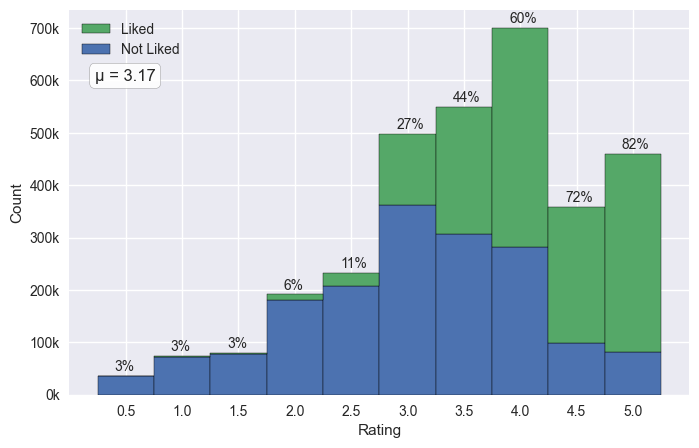

In [354]:
fig, ax = plt.subplots(figsize=(8,5))
bar_width = 1
x = np.arange(len(ratings))  # Bar positions

# plot not-liked
ax.bar(x, not_liked, label="Not Liked", width=bar_width, edgecolor='black')
# plot liked
ax.bar(x, liked, label="Liked", bottom=not_liked, width=bar_width, edgecolor='black')

percentages = np.round(liked / (liked + not_liked) * 100, 0).astype(int)

for i in range(len(ratings)):
    ax.text(x[i] - 0.2, (liked + not_liked + 10000)[i], f'{percentages[i]}%')

ax.text(-0.55, 600000,
         f'μ = {np.round(np.mean(df_merged["rating"]), 2)}',
         size=12, bbox=dict(boxstyle='round', fc='w', ec='0.5', alpha=0.9))

plt.xticks(x, ratings)
# convert y-axis labels to # of thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x * 1e-3)))
plt.xlabel('Rating')
plt.ylabel('Count')

# rearrange legend labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')

# save plot
plt.savefig('visualizations/rating_dist.png', bbox_inches='tight')
plt.show()

In [323]:
def add_mean_liked_review_rating(df):
    liked_reviews = df['liked_reviews']
    all_mean_rev_ratings = []
    # filter out unrated reviews
    all_ratings = [list(r.values()) for r in liked_reviews.values if r != 0]
    for ratings in all_ratings:
        ratings = [r for r in ratings if r != 0]
        # only add if there is at least one rated liked review and its is nonzero
        if len(ratings) > 0:
            all_mean_rev_ratings.append(np.mean(ratings))
        else: 
            all_mean_rev_ratings.append(0)

    df['mean_liked_reviews_rating'] = all_mean_rev_ratings
    df_merged['num_liked_reviews'] = [len(r) for r in all_ratings]

    return df

In [324]:
df_merged = add_mean_liked_review_rating(df_merged)

In [379]:
df_merged = df_merged.drop(['num_half_star', 'num_one_star', 'num_one_half_star', 
                'num_two_star', 'num_two_half_star', 'num_three_star', 
                'num_three_half_star', 'num_four_star', 'num_four_half_star', 
                'num_five_star'], axis=1)

### Textual data

In [137]:
from transformers import RobertaModel, RobertaTokenizerFast

In [140]:
model = RobertaModel.from_pretrained('distillbert')

You are using a model of type distilbert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of RobertaModel were not initialized from the model checkpoint at distillbert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermedia

In [142]:
tokenizer = RobertaTokenizerFast.from_pretrained('distillbert')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [177]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [155]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [192]:
# Sample dataset
reviews = df_merged['movie_desc'][25]

# Tokenize in batches
batch = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")
outputs = model(**batch)
# Convert logits to probabilities and extract emotions
probabilities = torch.softmax(outputs.logits, dim=1)
emotion_labels = [f'{model.config.id2label[i]}: {probabilities[0][i]}' for i in range(len(probabilities[0]))]
emotion_labels

['admiration: 0.004537475295364857',
 'amusement: 0.00391634413972497',
 'anger: 0.002494374057278037',
 'annoyance: 0.012227891013026237',
 'approval: 0.03225939720869064',
 'caring: 0.0012797937961295247',
 'confusion: 0.00451091630384326',
 'curiosity: 0.003772052237764001',
 'desire: 0.0033089190255850554',
 'disappointment: 0.010382961481809616',
 'disapproval: 0.00819103978574276',
 'disgust: 0.0029440184589475393',
 'embarrassment: 0.002435956383123994',
 'excitement: 0.0032268348149955273',
 'fear: 0.002079088008031249',
 'gratitude: 0.0003875123802572489',
 'grief: 0.00046583887888118625',
 'joy: 0.002280355663970113',
 'love: 0.0006060771411284804',
 'nervousness: 0.0019875564612448215',
 'optimism: 0.008771467953920364',
 'pride: 0.0012876804685220122',
 'realization: 0.040092695504426956',
 'relief: 0.0009635561727918684',
 'remorse: 0.0007516957120969892',
 'sadness: 0.003109114710241556',
 'surprise: 0.007060646545141935',
 'neutral: 0.8346689343452454']

In [193]:
df_merged

,rating,review,review_date,movie,user_x,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags,review_week,review_weekday,user_y,review_neg,review_neu,review_pos,review_comp,movie_name,movie_year_y,movie_tagline,movie_desc,movie_len,genres,top_keywords,in_collection,collection_name,studios,countries,primary_language,spoken_langauges,imdb_id,tmdb_id,cast,crew,num_watched,num_listed,num_liked,top_250_rank,avg_rating,percent_liked,year_adjusted,genre_Action,genre_Action-packed space and alien sagas,genre_Adventure,genre_Air pilot heroism and survival,genre_Animation,genre_Charming romances and delightful chemistry,genre_Chilling experiments and classic monster horror,genre_Comedy,genre_Crime,"genre_Crime, drugs and gangsters",genre_Dangerous technology and the apocalypse,genre_Disastrous voyages and heroic survival,genre_Documentary,genre_Drama,genre_Emotional LGBTQ relationships,genre_Emotional and captivating fantasy storytelling,genre_Epic adventure and breathtaking battles,genre_Epic heroes,genre_Extreme gory horror and cannibalism,genre_Fairy-tale fantasy and enchanted magic,genre_Faith and religion,genre_Faith and spiritual journeys,genre_Family,genre_Fantasy,"genre_Fantasy adventure, heroism, and swordplay","genre_Gory, gruesome, and slasher horror",genre_Graphic violence and brutal revenge,genre_Historical battles and epic heroism,genre_History,genre_Holiday joy and heartwarming Christmas,genre_Horror,"genre_Horror, the undead and monster classics",genre_Humanity and the world around us,genre_Humanity's odyssey: earth and beyond,genre_Imaginative space odysseys and alien encounters,genre_Intense combat and martial arts,genre_Laugh-out-loud relationship entanglements,"genre_Monsters, aliens, sci-fi and the apocalypse",genre_Moving relationship stories,genre_Music,genre_Mystery,genre_Powerful poetic and passionate drama,genre_Quirky and endearing relationships,genre_Relationship comedy,"genre_Religious faith, sin, and forgiveness",genre_Romance,"genre_Sci-fi horror, creatures, and aliens",genre_Sci-fi monster and dinosaur adventures,genre_Science Fiction,genre_Show All…,genre_Superheroes in action-packed battles with villains,genre_Surreal and thought-provoking visions of life and death,genre_TV Movie,"genre_Terrifying, haunted, and supernatural horror",genre_Thought-provoking sci-fi action and future technology,genre_Thriller,genre_Touching and sentimental family stories,genre_Tragic sadness and captivating beauty,genre_Twisted dark psychological thriller,genre_Underdogs and coming of age,"genre_Violent action, guns, and crime",genre_Violent crime and drugs,genre_War,genre_Western,keyword_Action comedy and silly heroics,keyword_Action-packed space and alien sagas,keyword_Adorable animals and heartwarming families,keyword_Adrenaline-fueled action and fast cars,keyword_Air pilot heroism and survival,keyword_Amusing jokes and witty satire,keyword_Bloody vampire horror,keyword_Bollywood emotional dramas,keyword_Bravery in War,"keyword_Brutal, violent prison drama",keyword_Captivating relationships and charming romance,keyword_Captivating vision and Shakespearean drama,keyword_Catchy songs and hilarious musical comedy,keyword_Challenging or sexual themes & twists,keyword_Charming romances and delightful chemistry,keyword_Chilling experiments and classic monster horror,"keyword_Creepy, chilling, and terrifying horror","keyword_Crime, drugs and gangsters",keyword_Crude humor and satire,keyword_Dance rhythms and catchy tunes,keyword_Dangerous technology and the apocalypse,keyword_Dazzling vocal performances and musicals,keyword_Disastrous voyages and heroic survival,"keyword_Dreamlike, quirky, and surreal storytelling",keyword_Emotional LGBTQ relationships,keyword_Emotional and captivating fantasy storytelling,keyword_Emotional and touching family dramas,keyword_Emotional life of renowned artists,keyword_Emotional teen coming-of-age stories,keyword_Enduring stories of family and marital drama,"keyword_Engagin

In [ ]:
model.config.id2label[i]

In [190]:
probabilities

tensor([[4.5375e-03, 3.9163e-03, 2.4944e-03, 1.2228e-02, 3.2259e-02, 1.2798e-03,
         4.5109e-03, 3.7721e-03, 3.3089e-03, 1.0383e-02, 8.1910e-03, 2.9440e-03,
         2.4360e-03, 3.2268e-03, 2.0791e-03, 3.8751e-04, 4.6584e-04, 2.2804e-03,
         6.0608e-04, 1.9876e-03, 8.7715e-03, 1.2877e-03, 4.0093e-02, 9.6356e-04,
         7.5170e-04, 3.1091e-03, 7.0606e-03, 8.3467e-01]],
       grad_fn=<SoftmaxBackward0>)

In [187]:
df_merged['movie_desc'][25]

'A thriller that revolves around the key people at an investment bank over a 24-hour period during the early stages of the financial crisis.'

In [173]:
df_merged['movie_desc'][1]

'Director Martin Scorsese profiles former Beatle George Harrison in this reverent portrait that mixes interviews and archival footage, featuring commentary from the likes of Paul McCartney, Eric Clapton, Ringo Starr and Yoko Ono.'

In [154]:
probabilities

tensor([[1.8811e-02, 7.8983e-01, 7.1677e-02, 1.1189e-01, 5.2469e-03, 2.5378e-03],
        [9.9539e-01, 1.0573e-03, 3.5970e-04, 2.1317e-03, 7.5950e-04, 3.0530e-04],
        [3.6382e-03, 2.1141e-01, 2.3785e-03, 3.1590e-03, 5.4569e-03, 7.7396e-01]])

In [151]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load tokenizer and model
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Emotion analysis pipeline
emotion_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Analyze text
text = ["This movie was thrilling and kept me on the edge of my seat!",
        "I didn't enjoy this at all. It was boring and too long."]
results = emotion_analyzer(text)
print(results)

[{'label': 'joy', 'score': 0.9220473766326904}, {'label': 'sadness', 'score': 0.8332684636116028}]


In [ ]:
model.

In [230]:
sia = SentimentIntensityAnalyzer()

def add_vader_score(review):
    if len(review) == 0:
        return [0., 1., 0., 0.]
    return list(sia.polarity_scores(review).values())

In [ ]:
vader_review_scores = df_merged['review'].apply(add_vader_score)

In [265]:
scores_df = pd.DataFrame(data=list(vader_review_scores.values), columns=['review_neg', 'review_neu', 'review_pos', 'review_comp'])a

In [268]:
df_merged = pd.merge(df_merged, scores_df, left_index=True, right_index=True)

In [280]:
df_merged.query('review_neu != 1. and liked == 1')['review_comp'].mean()

0.34779361552573673

In [ ]:
df_merged[['review_neg, review_neu', 'review_pos', 'review_comp']] = vader_review_scores

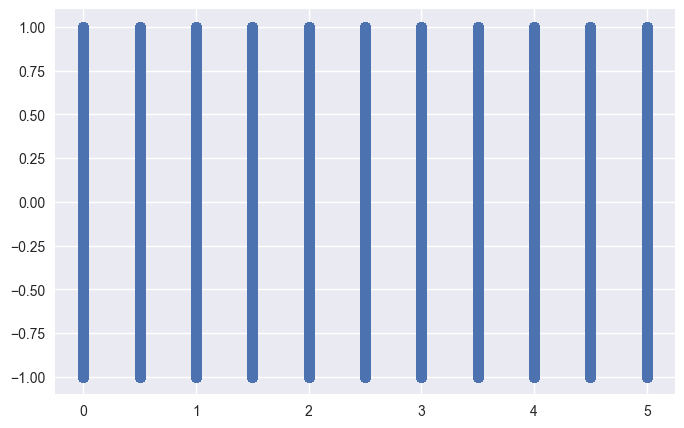

In [626]:
vader_sentiments = df_merged[df_merged['vader_review_score'] != 0.]
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(vader_sentiments['rating'], vader_sentiments['vader_review_score']);

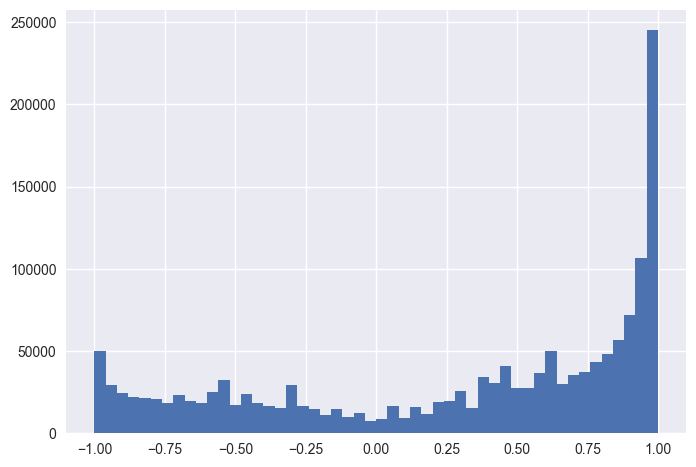

In [629]:
plt.hist(vader_sentiments['vader_review_score'], bins=50);

In [625]:
df_merged.columns

Index(['review', 'liked_reviews', 'when_watched', 'review_link', 'tags',
       'rewatched', 'movie_id', 'liked', 'movie', 'user', 'rating',
       'num_likes', 'movie_name', 'movie_year', 'movie_tagline', 'movie_desc',
       'movie_len', 'genres', 'top_keywords', 'in_collection',
       'collection_name', 'studios', 'countries', 'primary_language',
       'spoken_langauges', 'imdb_id', 'tmdb_id', 'cast', 'crew', 'num_watched',
       'num_listed', 'num_liked', 'top_250_rank', 'num_half_star',
       'num_one_star', 'num_one_half_star', 'num_two_star',
       'num_two_half_star', 'num_three_star', 'num_three_half_star',
       'num_four_star', 'num_four_half_star', 'num_five_star', 'mean_rating',
       'review_len', 'vader_review_score'],
      dtype='object')

### Representativeness of all Letterboxd users

The following scatterplot compares the popularity of movies in the entire Letterboxd community, on the x-axis, to their popularity in the dataset, on the y-axis. Perfect representation of the films would appear as a straight line with the equation f(x) = px, where p is the proportion of the dataset to all diary entries on the website. Fanning in the scatterplot shows that variation in sample representation increases as the popularity of a movie increases, and this variation appears to be greater for films which are overrepresented (i.e. above the line of fit) compared to other popular films. However, with an R^2 of 0.473, there is moderate correlation between these two factors, so it would be reasonable to say that the dataset is approximately representative of the userbase.

In [39]:
# count how many times each movie appears in our dataset
counts_per_movie = df_merged.groupby('movie_id').agg('count')[['review']].reset_index(drop=True)
counts_per_movie.rename(columns={'review': 'dataset_watched'}, inplace=True)

# merge these counts with our movies dataset and remove outliers
relative_watch_counts_merged = pd.merge(counts_per_movie, df_merged[['movie_id', 'num_watched']], on='movie_id', how='inner')

# convert all values to int and drop those which can't be converted
relative_watch_counts_merged['num_watched'] = pd.to_numeric(relative_watch_counts_merged['num_watched'])
relative_watch_counts_merged = relative_watch_counts_merged.dropna(subset=['num_watched'])

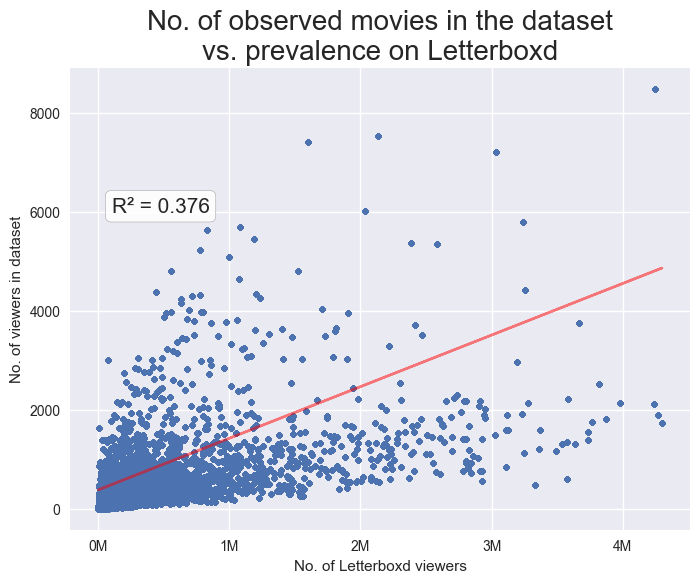

In [40]:
total_watched = relative_watch_counts_merged['num_watched']
dataset_watched = relative_watch_counts_merged['dataset_watched']

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(total_watched, dataset_watched, s=15)

a, b = np.polyfit(total_watched, dataset_watched, 1)
ax.plot(total_watched, a * total_watched + b, color='red', alpha=0.5)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}M'.format(x * 1e-6)))

# set title and labels
plt.title('No. of observed movies in the dataset' + \
          '\nvs. prevalence on Letterboxd', size=20)
plt.xlabel('No. of Letterboxd viewers')
plt.ylabel('No. of viewers in dataset')

# calculate R^2 correlation coefficient
corr = np.round(feature_selection.r_regression(relative_watch_counts_merged[['num_watched']], relative_watch_counts_merged['dataset_watched']) ** 2, 3)
plt.text(1e5, 6e3,
         f'R\u00b2 = {corr[0]}',
         size=15, bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
plt.show();

### Variance in movie release year

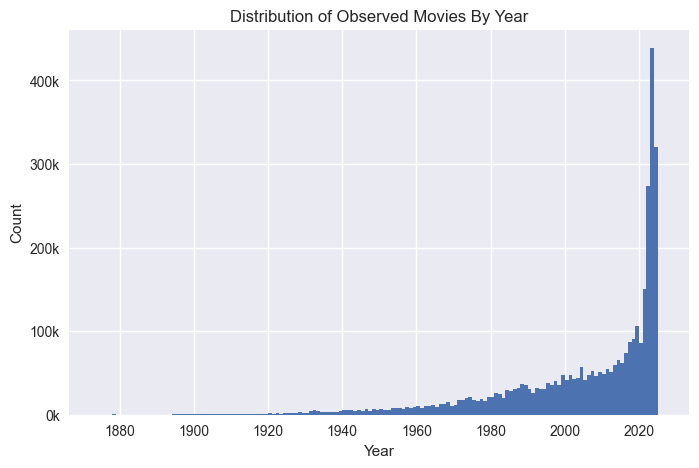

In [43]:
# set bounds for 
min_year = min(df_merged['movie_year'])
max_year = max(df_merged['movie_year'])

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(df_merged['movie_year'],
         bins=max_year-min_year
        )


ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x * 1e-3)))

plt.title('Distribution of Observed Movies By Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

### Variance in language

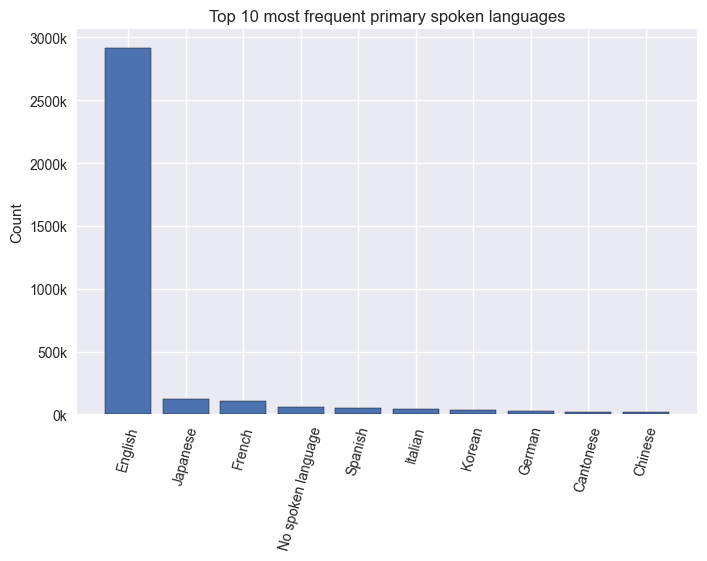

In [341]:
language_counts = df_merged['primary_language'].value_counts()[:10]

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(language_counts.index, language_counts.values, edgecolor='black')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x * 1e-3)))

plt.title('Top 10 most frequent primary spoken languages')
plt.ylabel('Count')

plt.xticks(rotation=75);

### Variance in countries

In [44]:
primary_country_counts = df_merged['countries'].value_counts().reset_index(drop=True)
primary_country_counts['countries'] = primary_country_counts['countries'].apply(lambda x: list(x.values()))

In [45]:
unique_countries = defaultdict(int)
for i in range(len(primary_country_counts)):
    lst = primary_country_counts['countries'][i]
    count = primary_country_counts['count'][i]
    for country in lst:
        unique_countries[country] += count

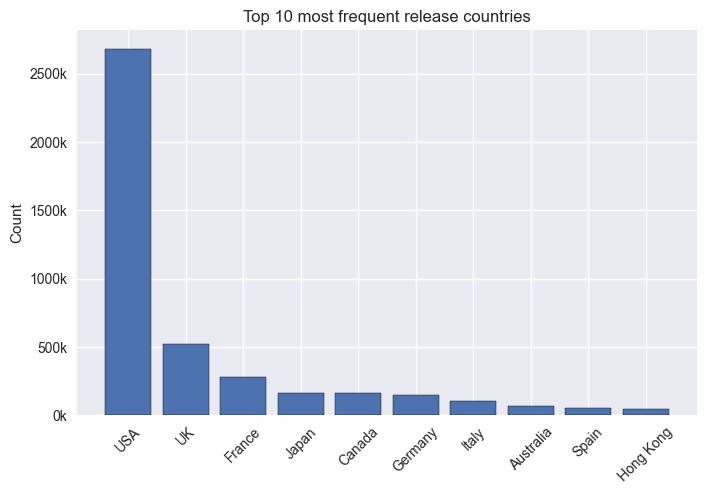

In [46]:
countries_df = pd.DataFrame(list(unique_countries.items()), columns=['country', 'count'])
countries_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(countries_df['country'][:10], countries_df['count'][:10], edgecolor='black')

plt.title('Top 10 most frequent release countries')
plt.ylabel('Count')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x * 1e-3)))
plt.xticks(rotation=45)

plt.show()

### Genre co-occurrence

In [50]:
# create value counts for each list of genres per movie
genre_counts = df_merged['genres'].value_counts().reset_index(drop=False)

KeyboardInterrupt: 

In [55]:
df_merged = df_merged.rename({'review_date_x': 'review_date'}, axis=1)

In [ ]:
# create set to hold all unique genres
unique_genres = set()

# iterate through all lists of genres per movie and add to `unique_genres`
for genre_list in list(genre_counts['genres']):
    for g in genre_list:
        # only include actual genres rather than keywords
        if len(g.split()) <= 2 and g != 'Show All…':
            unique_genres.add(g)

unique_genres = list(unique_genres)
unique_genres.sort()
unique_genres[:5]

In [ ]:
# filter genres to only include Letterboxd's recognized genres
filtered_genre_lists = [
    [genre for genre in genres if genre in unique_genres]
    for genres in genre_counts['genres'] if len(genres) > 1
]

# create list of all two-genre tuple combinations for co-occurences
combined_genres = [list(combinations(genres, 2)) for genres in genre_counts['genres']]

In [ ]:
# create co-occurrence matrix
co_matrix = pd.DataFrame(0, index=unique_genres, columns=unique_genres, dtype=int)

# counter to index 
j = 0

# fill co-occurrence matrix
for i in list(genre_counts.index):
    combo = combined_genres[j]
    count = genre_counts['count'][i]
    for genre1, genre2 in combo:
        if genre1 in unique_genres and genre2 in unique_genres:
            sorted_genres = [genre1, genre2]
            sorted_genres.sort()
            co_matrix.loc[genre1,genre2] += count
            co_matrix.loc[genre2,genre1] += count
    j += 1

# remove non-genres
co_matrix = co_matrix.drop('Epic heroes').drop('Epic heroes', axis=1)
co_matrix = co_matrix.drop('Relationship comedy').drop('Relationship comedy', axis=1)

In [ ]:
# create empty graph
G = nx.Graph()

# create node weights based on occurrence of each genre
node_weights = co_matrix.sum(axis=1)

# add nodes with weights to graph
for genre, weight in node_weights.items():
    G.add_node(genre, weight=weight)

# add edges with weights to graph
for genre1 in co_matrix.index:
    for genre2 in co_matrix.columns:
        if genre1 != genre2 and co_matrix.loc[genre1, genre2] > 0:
            G.add_edge(genre1, genre2, weight=co_matrix.loc[genre1, genre2])

node_sizes = [G.nodes[node]['weight'] / 500 for node in G.nodes]
edge_weights = [G[u][v]['weight'] / 100000 for u, v in G.edges]

# map edge weights to colors
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('viridis')
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# create figure
fig = plt.figure(figsize=(12, 8))
grid = fig.add_gridspec(1, 2, width_ratios=[4, 0.5], wspace=0.15)

# plot network
ax_graph = fig.add_subplot(grid[0, 0])
nx.draw_shell(
    G,
    ax=ax_graph,
    with_labels=True,
    node_size=node_sizes,
    width=edge_weights,
    font_size=10,
    edge_color=edge_colors,
    node_color='lightblue',
)

# add edge weight colorbar
ax_cbar = fig.add_subplot(grid[0, 1])
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=ax_cbar, label='Number of co-occurrences')

# adjust colorbar tick values
tick_values = np.arange(0, 3.6, 0.5)
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f"{int(value * 100000):,}" for value in tick_values]) 

plt.savefig('visualizations/genre_cooccurrence_network.png', bbox_inches='tight')
plt.show()

In [228]:
## plot keywords co-occurrence

In [333]:
keywords_freq = df_merged['top_keywords'].value_counts().reset_index()

In [334]:
keywords_freq

,top_keywords,count
0,[],215761
1,"[Humanity and the world around us, Crude humor...",6940
2,"[Humanity and the world around us, Politics an...",5847
3,"[Humanity and the world around us, Surreal and...",5351
4,"[Epic heroes, Humanity and the world around us...",5299
...,...,...
15506,"[Humanity and the world around us, Legendary m...",1
15507,"[Horror, the undead and monster classics, Gory...",1
15508,"[Moving relationship stories, Emotional and to...",1
15509,"[Horror, the undead and monster classics, Gory...",1


In [335]:
all_keywords = []
for k in keywords_freq['top_keywords']:
    all_keywords.extend(k)

In [342]:
unique_keywords = list(set(all_keywords))
unique_keywords.sort()

In [352]:
keywords_tuples = [list(combinations(kws, 2)) for kws in keywords_freq['top_keywords']]
len(keywords_tuples)

15511

In [350]:
len(keywords_freq)

15511

In [353]:
co_matrix_keywords = pd.DataFrame(0, index=unique_keywords, columns=unique_keywords)

j = 0
for i in list(keywords_freq.index):
    combo = keyword_tuples[j]
    count = keywords_freq['count'][i]
    for kw1, kw2 in combo:
        sorted_genres = [kw1, kw2]
        sorted_genres.sort()
        co_matrix_keywords.loc[kw1,kw2] += count
        co_matrix_keywords.loc[kw2,kw1] += count
    j += 1

In [354]:
co_matrix_keywords

,Action comedy and silly heroics,Action-packed space and alien sagas,Adorable animals and heartwarming families,Adrenaline-fueled action and fast cars,Air pilot heroism and survival,Amusing jokes and witty satire,Bloody vampire horror,Bollywood emotional dramas,Bravery in War,"Brutal, violent prison drama",...,Tragic sadness and captivating beauty,Twisted dark psychological thriller,Underdog fighting and boxing stories,Underdogs and coming of age,"Violent action, guns, and crime",Violent crime and drugs,War and historical adventure,Western frontier dramas with a touch of humor,Westerns,Wild west outlaws and gunfights
Action comedy and silly heroics,0,15694,2552,28174,177,25351,2895,159,54,540,...,0,909,63,8134,8678,201,767,265,357,276
Action-packed space and alien sagas,15694,0,2515,3739,29,746,764,112,251,0,...,1,3260,17,273,1016,73,5237,56,386,57
Adorable animals and heartwarming families,2552,2515,0,733,23,4407,27,5,31,0,...,50,0,0,2628,0,0,26,0,0,0
Adrenaline-fueled action and fast cars,28174,3739,733,0,4683,2498,348,97,4366,3279,...,0,1376,1721,969,24875,3406,792,21,636,223
Air pilot heroism and survival,177,29,23,4683,0,7,0,0,7239,11,...,0,1022,0,0,122,0,2729,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Violent crime and drugs,201,73,0,3406,0,32,588,325,0,14007,...,1275,7156,1113,1390,29548,0,115,964,1556,1457
War and historical adventure,767,5237,26,792,2729,3013,73,24,14460,626,...,812,216,0,30,3821,115,0,63,104,32
Western frontier dramas with a touch of humor,265,56,0,21,0,512,14,203,32,475,...,0,732,17,0,6484,964,63,0,10770,10245
Westerns,357,386,0,636,1,539,336,212,40,600,...,0,1004,0,0,9190,1556,104,10770,0,12707


In [361]:
kw_mapping = {co_matrix_kws.index[i]: i for i in range(len(co_matrix_kws.index))}
kw_mapping

{'Action comedy and silly heroics': 0,
 'Action-packed space and alien sagas': 1,
 'Adorable animals and heartwarming families': 2,
 'Adrenaline-fueled action and fast cars': 3,
 'Air pilot heroism and survival': 4,
 'Amusing jokes and witty satire': 5,
 'Bloody vampire horror': 6,
 'Bollywood emotional dramas': 7,
 'Bravery in War': 8,
 'Brutal, violent prison drama': 9,
 'Captivating relationships and charming romance': 10,
 'Captivating vision and Shakespearean drama': 11,
 'Catchy songs and hilarious musical comedy': 12,
 'Challenging or sexual themes & twists': 13,
 'Charming romances and delightful chemistry': 14,
 'Chilling experiments and classic monster horror': 15,
 'Creepy, chilling, and terrifying horror': 16,
 'Crime, drugs and gangsters': 17,
 'Crude humor and satire': 18,
 'Dance rhythms and catchy tunes': 19,
 'Dangerous technology and the apocalypse': 20,
 'Dazzling vocal performances and musicals': 21,
 'Disastrous voyages and heroic survival': 22,
 'Dreamlike, quirky

In [367]:
# create empty graph
G = nx.Graph()

node_weights = co_matrix_kws.sum(axis=1)

# add notes to graph based on weights
for kw, weight in node_weights.items():
    G.add_node(kw, weight=weight)

co_matrix_kw_values = co_matrix_kws.values

# Add edges with weights
for kw1 in co_matrix_kws.index:
    for kw2 in co_matrix_kws.columns:
        if kw1 != kw2 and co_matrix_kw_values[kw_mapping[kw1]][kw_mapping[kw2]] > 0:
            G.add_edge(kw1, kw2, weight=co_matrix_kw_values[kw_mapping[kw1]][kw_mapping[kw2]])
        # if kw1 != kw2 and co_matrix_kws.loc[kw1, kw2] > 0:
        #     G.add_edge(kw1, kw2, weight=co_matrix_kws.loc[kw1, kw2])

In [ ]:
# co_matrix_kws = co_matrix_keywords


# # create empty graph
# G = nx.Graph()

# node_weights = co_matrix_kws.sum(axis=1)

# # add notes to graph based on weights
# for kw, weight in node_weights.items():
#     G.add_node(kw, weight=weight)

# co_matrix_kw_values = co_matrix_kws.values

# # Add edges with weights
# for kw1 in co_matrix_kws.index:
#     for kw2 in co_matrix_kws.columns:
#         if kw1 != kw2 and co_matrix_kw_values[kw_mapping[kw1]][kw_mapping[kw2]] > 0:
#             G.add_edge(kw1, kw2, weight=co_matrix_kw_values[kw_mapping[kw1]][kw_mapping[kw2]])
#         # if kw1 != kw2 and co_matrix_kws.loc[kw1, kw2] > 0:
#         #     G.add_edge(kw1, kw2, weight=co_matrix_kws.loc[kw1, kw2])

node_sizes = [G.nodes[node]['weight'] for node in G.nodes]
edge_widths = [G[u][v]['weight'] for u, v in G.edges]

# Normalize edge weights and map to colors
norm = mcolors.Normalize(vmin=min(edge_widths), vmax=max(edge_widths))
cmap = cm.get_cmap('viridis')
edge_colors = [cmap(norm(weight)) for weight in edge_widths]

# Create a figure with a grid layout
fig = plt.figure(figsize=(12, 8))
grid = fig.add_gridspec(1, 2, width_ratios=[4, 0.5], wspace=0.2)

# Plot the graph on the left
ax_graph = fig.add_subplot(grid[0, 0])
nx.draw_shell(
    G,
    ax=ax_graph,
    with_labels=True,
    node_size=node_sizes,
    width=edge_widths,
    font_size=10,
    edge_color=edge_colors,
    node_color='lightblue',
)
ax_graph.set_title("Movie Genre Co-occurrence Network")

# Add the colorbar on the right
ax_cbar = fig.add_subplot(grid[0, 1])
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar
cbar = plt.colorbar(sm, cax=ax_cbar)
cbar.set_label("Count of co-occurrences")

tick_values = np.arange(0, max(edge_widths) )
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f"{int(value * 100000):,}" for value in tick_values]) 

plt.show()

/var/folders/kf/zhjfx0v13bl2vbc_p3zqngz80000gp/T/ipykernel_32183/280598389.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


### Temporal analysis

In [121]:
def get_year_data(year):
    date_grouped = (df_merged.query(f'review_date >= "{year}-01-01" and review_date < "{year+1}-01-01"')
                    [['review_date', 'review_week', 'rating', 'review']]
                    .groupby('review_week')
                    .agg({'rating': 'mean', 'review': 'count'})
                    .reset_index(drop=False)
                   )
    return date_grouped

In [122]:
grouped_2020 = get_year_data(2020)
grouped_2021 = get_year_data(2021)
grouped_2022 = get_year_data(2022)
grouped_2023 = get_year_data(2023)
grouped_2024 = get_year_data(2024)

In [221]:
rolling_rating = df_merged['rating'].rolling(window=100000).mean()
rolling_liked = df_merged['liked'].rolling(window=100000).mean()

In [65]:
df_time_axis = df_merged.set_index('review_date')
rolling_ratings = df_time_axis.query('review_date >= "2020-01-01"')['rating'].rolling(window=100000).mean()
rolling_likes = df_time_axis.query('review_date >= "2020-01-01"')['liked'].rolling(window=100000).mean()

In [370]:
df_merged.columns

Index(['rating', 'review', 'review_date', 'movie', 'user', 'review_link',
       'movie_id', 'num_likes', 'liked', 'rewatched', 'liked_reviews', 'tags',
       'movie_name', 'movie_year', 'movie_tagline', 'movie_desc', 'movie_len',
       'genres', 'top_keywords', 'in_collection', 'collection_name', 'studios',
       'countries', 'primary_language', 'spoken_langauges', 'imdb_id',
       'tmdb_id', 'cast', 'crew', 'num_watched', 'num_listed', 'num_liked',
       'top_250_rank', 'num_half_star', 'num_one_star', 'num_one_half_star',
       'num_two_star', 'num_two_half_star', 'num_three_star',
       'num_three_half_star', 'num_four_star', 'num_four_half_star',
       'num_five_star', 'review_week', 'review_weekday', 'review_neg',
       'review_neu', 'review_pos', 'review_comp', 'mean_liked_reviews_rating',
       'num_liked_reviews'],
      dtype='object')

In [93]:
rolling_ratings = df_time_axis.query('review_date >= "2018-01-01"')['rating'].rolling(window=100000).mean()
rolling_likes = df_time_axis.query('review_date >= "2018-01-01"')['liked'].rolling(window=100000).mean()
rolling_comp = df_time_axis.query('review_date >= "2018-01-01"')['review_comp'].rolling(window=100000).mean()

In [101]:
rolling_ratings = rolling_ratings.reset_index().query('review_date >= "2021-01-01"').set_index('review_date')
rolling_likes = rolling_likes.reset_index().query('review_date >= "2021-01-01"').set_index('review_date')

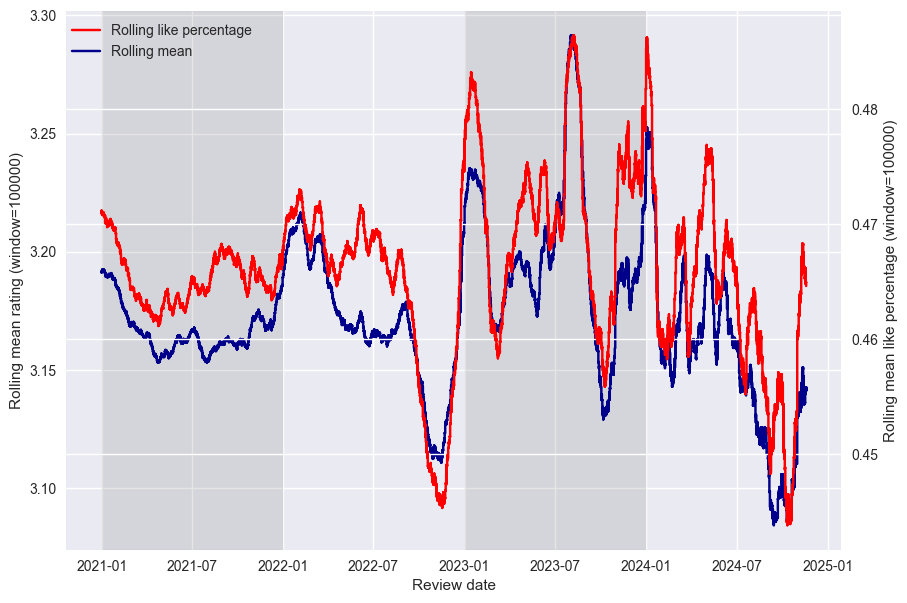

In [135]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(rolling_ratings, color='darkblue', label='Rolling mean')

ax2 = ax.twinx()
ax2.plot(rolling_likes, color='red', label='Rolling like percentage')

ax.axvspan("2021-01-01", "2022-01-01", color="gray", alpha=0.2)
ax.axvspan("2023-01-01", "2024-01-01", color="gray", alpha=0.2)

plt.xticks(rotation=45)
ax.legend(loc=(0,.90))
ax2.legend(loc=(0,.94))

ax.set_xlabel('Review date')

ax.set_ylabel('Rolling mean rating (window=100000)')
ax2.set_ylabel('Rolling mean like percentage (window=100000)')

plt.savefig('visualizations/time_series_plot.png', bbox_inches='tight')

plt.xticks(rotation=45)

plt.show()

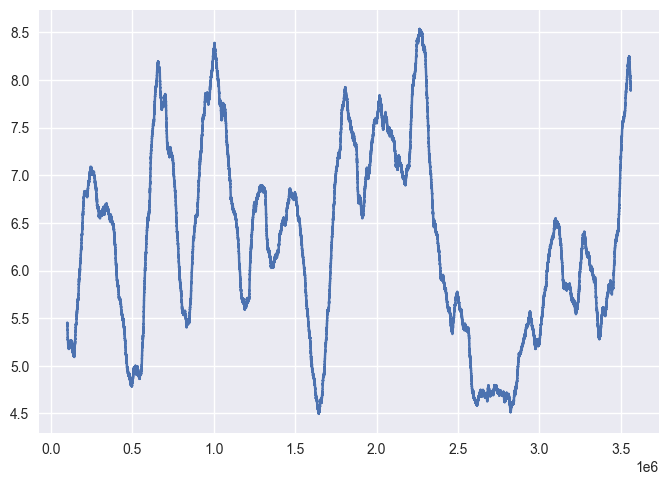

In [372]:
plt.plot(df_merged['top_250_rank'].rolling(100000).mean());

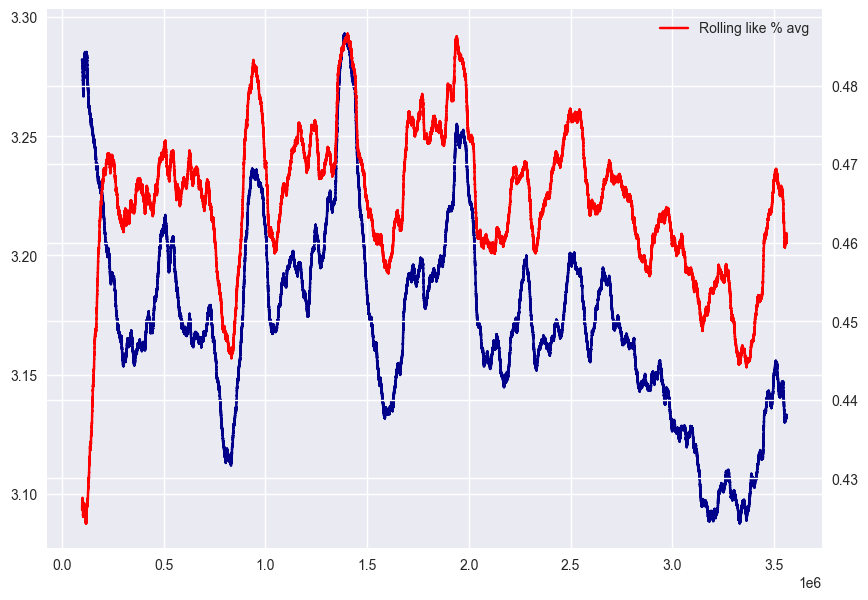

In [335]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(x=rolling_rating, color='darkblue', label='Rolling rating avg');

ax.twinx().plot(rolling_liked, color='red', label='Rolling like % avg')

plt.legend()

plt.show()

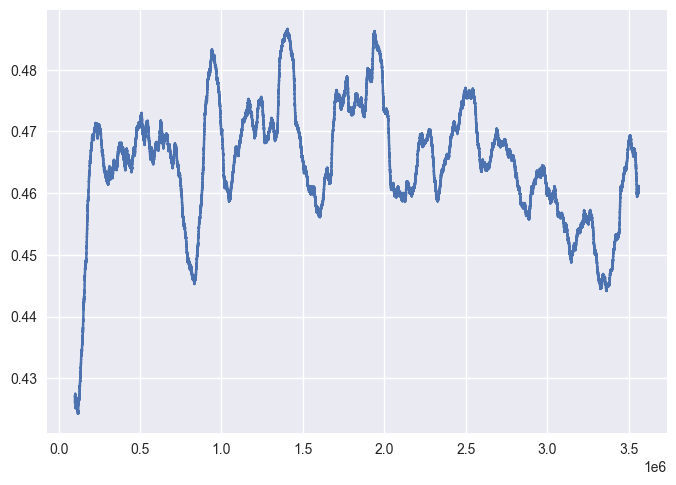

In [243]:
plt.plot(rolling_liked);

In [234]:
rolling_avg[1.38e6]

3.285975

In [235]:
1.38e6

1380000.0

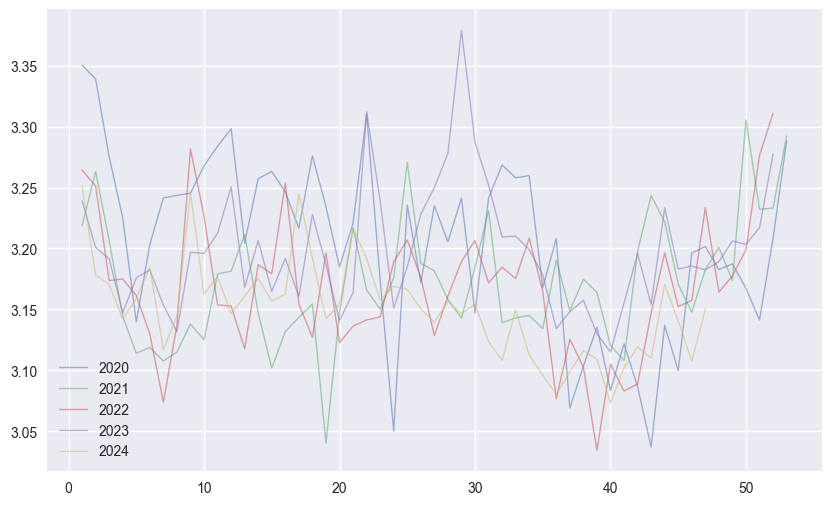

In [223]:
all_grouped = [(grouped_2020, 2020), (grouped_2021, 2021), (grouped_2022, 2022), (grouped_2023, 2023), (grouped_2024, 2024)]

fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(grouped_2020['review_week'], grouped_2020['rating'], linewidth=1, color='red', alpha=0.25)

for g in all_grouped:
    ax.plot(g[0]['review_week'], g[0]['rating'], linewidth=1, alpha=0.5, label=g[1])

plt.legend()

plt.show()

In [197]:
def get_week_data(week):
    date_grouped = (df_merged.query(f'review_week == {week} and review_date >= "2024-01-01"')
                    [['review_date', 'review_weekday', 'rating', 'review']]
                    .groupby('review_weekday')
                    .agg({'rating': 'mean', 'review': 'count'})
                    .reset_index(drop=False)
                   )
    return date_grouped

In [184]:
week_2 = get_week_data(6)

In [185]:
week_2

,review_weekday,rating,review
0,0,3.161624,482575
1,1,3.158923,470782
2,2,3.153733,467270
3,3,3.163327,473221
4,4,3.166537,508563
5,5,3.197191,575114
6,6,3.204621,583255


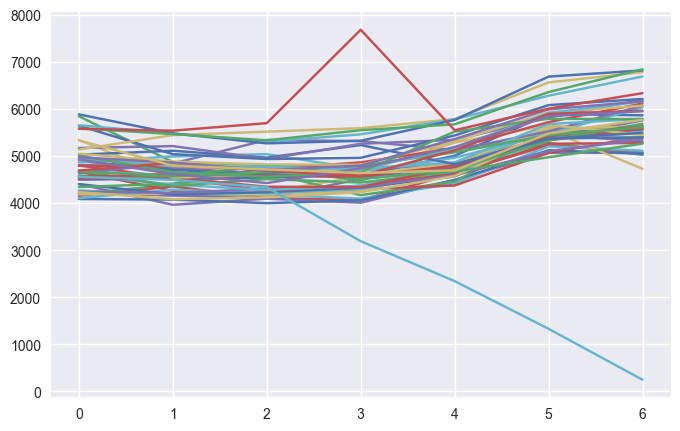

In [198]:
fig, ax = plt.subplots(figsize=(8,5))

for i in range(52):
    week = get_week_data(i)
    ax.plot(week['review_weekday'], week['review'])

plt.show()

In [120]:
grouped_2020

,review_week,rating,review
0,1,3.489547,287


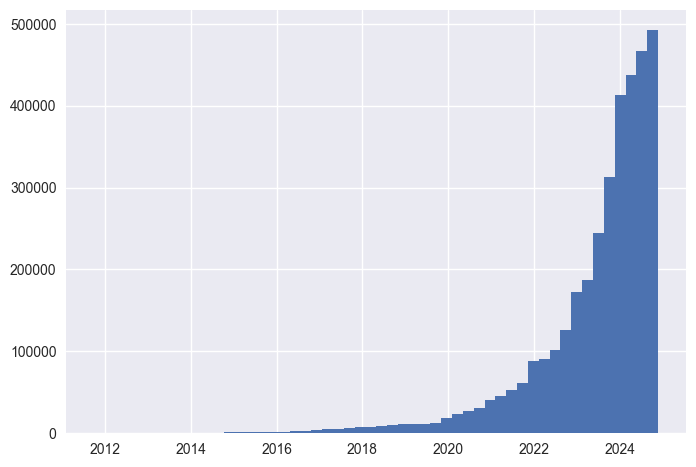

In [103]:
plt.hist(df_merged['review_date'], bins=);

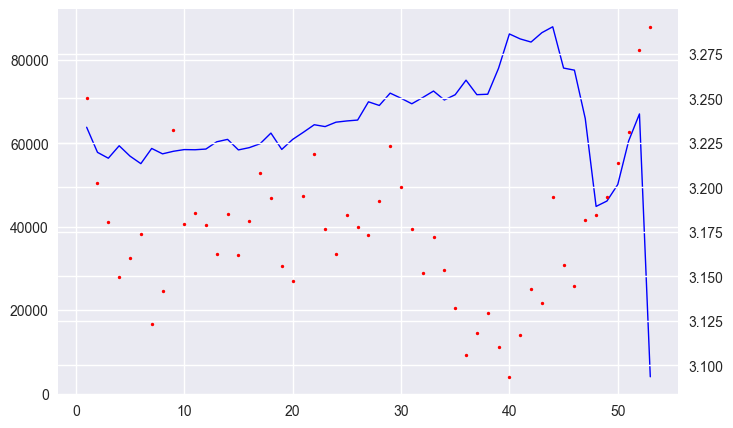

In [113]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax2 = ax1.twinx()

ax1.plot(date_grouped['review_week'], date_grouped['review'], linewidth=1, color='blue')
ax2.scatter(date_grouped['review_week'], date_grouped['rating'], linewidth=1, color='red', s=2)
plt.show()

## Assessing variation across features

In [352]:
average_ratings = df_merged[df_merged['rating'] != 0][['movie', 'rating']].groupby('movie').agg(np.mean).reset_index()

top_30_movies = df_merged[['movie', 'top_genre', 'movie_year_x']].value_counts().reset_index()
top_30_movies = pd.merge(top_30_movies, average_ratings, on='movie', how='inner').loc[:30,]

KeyboardInterrupt: 

In [91]:
def map_year_to_color(year):
    if year == 2024:
        return 'red'
    elif year == 2023:
        return 'blue'
    elif year == 2022:
        return 'green'
    elif year == 2021:
        return 'cyan'
    elif year == 2019:
        return 'purple'
    elif year == 2016:
        return 'brown'
    elif year == 1996:
        return 'orange'

colors = top_30_movies['movie_year_x'].apply(map_year_to_color).values

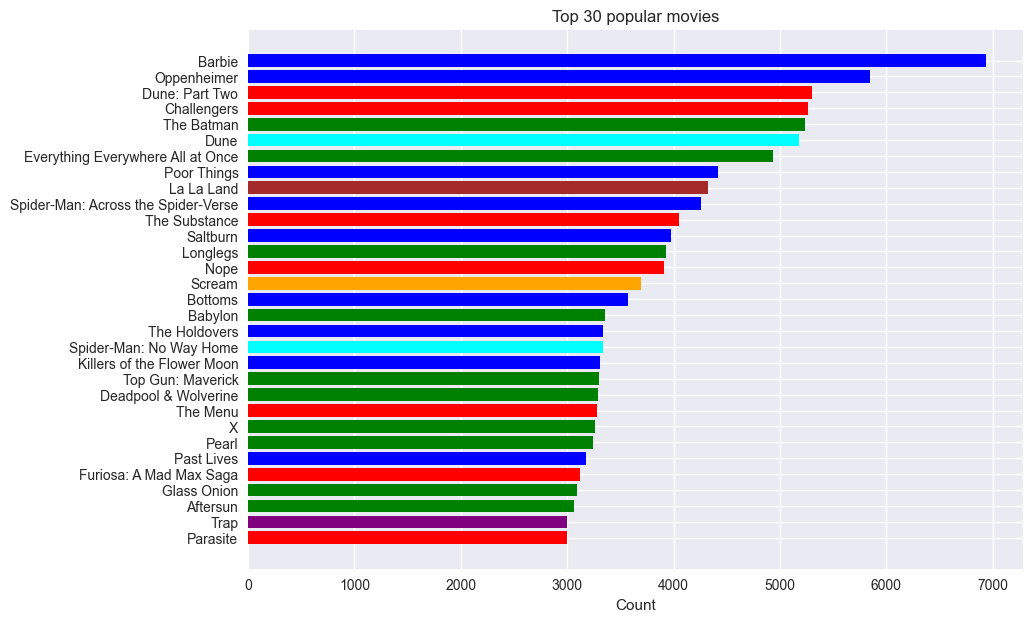

In [225]:

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(top_30_movies['movie'], top_30_movies['count'], color=colors)

plt.gca().invert_yaxis()

plt.title('Top 30 popular movies')
plt.xlabel('Count')
plt.yticks(fontsize=10)
plt.show()

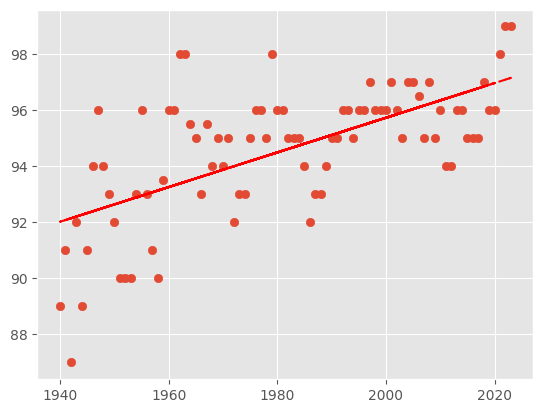

In [220]:
subset = movie_data[(movie_data['movie_year'].isin(np.arange(1940, 2024))) & (movie_data['movie_len'] > 45)].copy().reset_index()
year_dist = defaultdict(list)

for i in range(len(subset['movie_year'])):
    year = subset.loc[i, 'movie_year']
    year_dist[year].append(subset.loc[i,'movie_len'])

year_dist = dict(year_dist)
for i in range(len(year_dist)):
    year = list(year_dist.keys())[i]
    year_mean = np.median(year_dist[year])
    year_dist[year] = year_mean

years = zip(list(year_dist.keys()), list(year_dist.values()))
all_years, year_mean_lens = zip(*years)

plt.scatter(all_years, year_mean_lens);
z = np.polyfit(all_years, year_mean_lens, 1)
p = np.poly1d(z)
plt.plot(all_years,p(all_years),"r--")

In [417]:
countries = defaultdict(int)
for lst in df_merged['primary_language'].value_counts():
    countries[c] += 1

# Modeling

### User features

In [ ]:
user_data = (df_merged[['user', 'movie_id', 'rating', 'movie_len']]
             .groupby('user')
             .agg({'rating': 'mean', 'movie_len': np.median, })

In [ ]:
df_merged['mean_rating']

In [381]:
len(df_merged['user'].unique())

7705

user_df = 

In [622]:
# Add the mean rating of reviews liked by each user for each entry
def add_mean_liked_review_rating(df):
    liked_reviews = df['liked_reviews']
    all_mean_rev_ratings = []
    # filter out unrated reviews
    curr_ratings = [r for r in liked_reviews.values() if r != 0]
    for review in liked_reviews:
        curr_ratings = [r for r in liked_reviews.values() if r != 0]
        # only add if there is at least one rated liked review
        if len(curr_ratings) > 0:
            all_mean_rev_ratings.append(np.mean(curr_ratings))
        else:
            all_mean_rev_ratings.append(0)

    df['mean_liked_reviews_rating'] = all_mean_rev_ratings
    df_merged['num_liked_reviews'] = df_merged['liked_reviews'].apply(lambda x: len(x) if isinstance(x, (list, dict)) else 0)

    return df

# Add what the predicted language of the review is
def add_review_language(df):
    reviews = df['review']
    languages = []
    for r in reviews:
        try:
            detected = detect(r)
            languages.append(detected)
        except LangDetectException as e:
            languages.append('Unknown')
    df['review_language'] = languages
    return df

def add_review_lang(r):
    try:
        d = detect(r)
        return d
    except LangDetectException:
        return 'Unknown'

def add_review_len(df):
    df['review_len'] = df['review'].apply(len)
    return df

def add_review_vader_scores(df):
    reviews = df['review']
    sia = SentimentIntensityAnalyzer()
    scores = [sia.polarity_scores(r)['compound'] if r is not None or r != '' else 0. for r in reviews]
    df['vader_review_score'] = scores
    return df

def add_popularity_index(df):
    ...

def add_rewatch_counter(df):
    ...
    # rewatch_totals = df_merged.groupby(['user', 'movie'])['rewatched'].transform('sum')
    # df_merged['rewatch_count'] = rewatch_totals


In [ ]:
df_merged = df_merged.pipe(add_mean_rating)

In [421]:
df_merged['review_len'] = df_merged['review'].apply(len)

<Axes: >

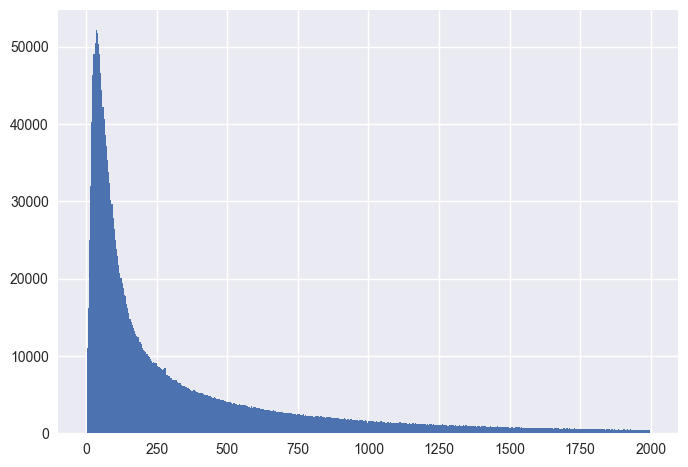

In [430]:
df_merged.query('review_len < 2000 and review_len > 0')['review_len'].hist(bins=500)

In [ ]:
df_merged = df_merged.pipe(add_review_vader_scores)

In [620]:
df_merged['liked_reviews']

0                                                         {}
1                                                         {}
2                          {'/miag0th/film/the-craft/': 3.5}
3                     {'/_laurelle/film/the-prestige/': 5.0}
4                           {'/h4nnuh/film/fall-2022/': 2.5}
                                 ...                        
1962866              {'/liamflynn_/film/office-space/': 4.5}
1962867           {'/incomingmail/film/suspiria-2018/': 3.5}
1962868    {'/mulaney/film/everything-everywhere-all-at-o...
1962869               {'/shanderson88/film/contagion/': 4.0}
1962870    {'/alderaanch/film/drake-josh-go-hollywood/': ...
Name: liked_reviews, Length: 1962871, dtype: object

In [611]:
%%timeit
df_merged['review'][:10].apply(add_review_lang)

40.9 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
df_merged = df_merged.pipe(add_review_language)

In [612]:
df_merged = df_merged.pipe(add_review_len)

In [ ]:
df_merged = df_merged

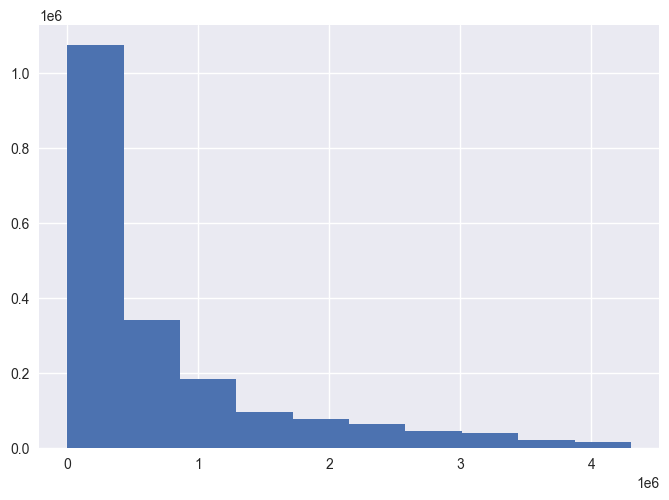

In [558]:
plt.hist(df_merged['num_watched']);

In [496]:
# add mean rating of each movie based on Letterboxd statistics
df_merged = df_merged.pipe(add_mean_rating)

In [ ]:
rating_cols = ['num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
                   'num_two_half_star', 'num_three_star', 'num_three_half_star', 'num_four_star',
                   'num_four_half_star', 'num_five_star', 'num_liked']

sns.pairplot(df_merged[rating_cols]);

In [460]:
df_merged[['user', 'movie', 'liked_reviews', 'mean_liked_reviews_rating']]

,user,movie,liked_reviews,mean_liked_reviews_rating
0,will_sloan,Close-Up,{},0
1,abnerfilms,Poor Things,{},0
2,khardy,The Craft,{'/miag0th/film/the-craft/': 3.5},0
3,alacyn,The Prestige,{'/_laurelle/film/the-prestige/': 5.0},0
4,rafefvs,Fall,{'/h4nnuh/film/fall-2022/': 2.5},0
...,...,...,...,...
1962866,jsignore,Office Space,{'/liamflynn_/film/office-space/': 4.5},0
1962867,hatchet,Suspiria,{'/incomingmail/film/suspiria-2018/': 3.5},0
1962868,juliannemooore,Everything Everywhere All at Once,{'/mulaney/film/everything-everywhere-all-at-o...,0
1962869,giulee,Contagion,{'/shanderson88/film/contagion/': 4.0},0


In [ ]:
all_features = ['rewatch_count',
                'review_len',
                'num_liked_reviews',
                'mean_liked_reviews_rating',
                'rating']

sns.pairplot(df_merged[all_features]);

## Test/validation/train split

For non-sequential modelling, we will use a 80/10/10 train/validation/test split.

In [ ]:
from sklearn

In [ ]:
Xtrain, ytrain, Xvalid_test, yvalid_test = model_selection.test_train_split(df_merged, test_size = 

In [229]:
df_merged

,rating,review,review_date,movie,user,review_link,movie_id,num_likes,liked,rewatched,liked_reviews,tags,movie_name,movie_year,movie_tagline,movie_desc,movie_len,genres,top_keywords,in_collection,collection_name,studios,countries,primary_language,spoken_langauges,imdb_id,tmdb_id,cast,crew,num_watched,num_listed,num_liked,top_250_rank,num_half_star,num_one_star,num_one_half_star,num_two_star,num_two_half_star,num_three_star,num_three_half_star,num_four_star,num_four_half_star,num_five_star,review_week,review_weekday
0,0.0,Recalling the incident in Turin that reportedl...,2011-10-01,The Turin Horse,notjro,/notjro/film/the-turin-horse/,the-turin-horse,7,0,0,{},[],The Turin Horse,2011,,A monumental windstorm and an abused horse's r...,155,[Drama],"[Humanity and the world around us, Surreal and...",0,,{'motion-picture-public-foundation-of-hungary'...,"{'france': 'France', 'germany': 'Germany', 'hu...",Hungarian,"[German, Hungarian]",1316540,81401,"{'János Derzsi': None, 'Erika Bók': None, 'Mih...","{'Béla Tarr': ['director', 'writer'], 'Ágnes H...",46587,27063,15645,0,253,360,216,680,742,2196,2975,8059,6109,9559,39,5
1,3.0,"Scorsese analyzes the mysteries of George ""Got...",2011-10-03,George Harrison: Living in the Material World,electricebert,/electricebert/film/george-harrison-living-in-...,george-harrison-living-in-the-material-world,0,0,0,{},[],George Harrison: Living in the Material World,2011,,Director Martin Scorsese profiles former Beatl...,208,"[Documentary, Music]","[Song and dance, Legendary musicians and stard...",0,,{'grove-street-pictures': 'Grove Street Pictur...,{},English,[],1113829,75964,"{'George Harrison': None, 'Olivia Harrison': N...","{'Martin Scorsese': ['director', 'producer'], ...",33204,8962,10190,0,21,32,20,146,259,1638,2595,7367,3058,4700,40,0
2,4.0,Full review on my blog: whitecitycinema.com/20...,2011-10-04,Within Our Gates,michaelgsmith,/michaelgsmith/film/within-our-gates/,within-our-gates,1,0,0,{},"[Oscar Micheaux, Within Our Gates, Silent Film]",Within Our Gates,1920,,"Abandoned by her fiancé, an educated black wom...",74,"[Romance, Drama, Crime]","[Politics and human rights, Racism and the pow...",0,,{'micheaux-book-film-company': 'Micheaux Book ...,{'usa': 'USA'},No spoken language,[],11870,77621,"{'Evelyn Preer': None, 'Flo Clements': None, '...","{'Oscar Micheaux': ['director', 'producer', 'w...",15014,10740,2884,0,36,113,133,465,726,2365,2009,2003,469,419,40,1
3,3.0,A sick man fights a sick system One of the gre...,2011-10-05,Puncture,electricebert,/electricebert/film/puncture/,puncture,0,0,0,{},[],Puncture,2011,Madman. Genius. Playboy. Friend. Fool. Lawyer.,A lawyer who is a drug addict fights a medical...,100,"[Drama, Mystery]","[Politics and human rights, Intense political ...",0,,"{'cherry-sky-films': 'Cherry Sky Films', 'volt...",{'usa': 'USA'},English,"[French, English]",1582248,72432,"{'Chris Evans': None, 'Michael Biehn': None, '...","{'Adam Kassen': ['director'], 'Mark Kassen': [...",11164,1863,1612,0,33,77,124,463,798,2107,1663,1045,173,334,40,2
4,4.0,A dread is spreading in the land Here is a fri...,2011-10-05,Take Shelter,electricebert,/electricebert/film/take-shelter/,take-shelter,0,0,0,{},[],Take Shelter,2011,Far away from the cruel world.,"Plagued by a series of apocalyptic visions, a ...",120,"[Drama, Thriller]","[Humanity and the world around us, Intense vio...",0,,"{'hydraulx': 'Hydraulx', 'rei-capital': 'REI C...",{'usa': 'USA'},English,[],1675192,64720,"{'Michael Shannon': None, 'Jessica Chastain': ...","{'Jeff Nichols': ['director', 'writer'], 'Tyle...",122744,32483,30071,0,144,478,501,2089,3292,11986,19295,29120,10886,7022,40,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560775,3.5,sorry but warren beatty writing “there is a bo...,2024-11-24,The Parallax View,filmcal,/filmcal/film/the-parallax-view/,the-parallax-view,2,0,0,{'/cambne

## 1. Memory-based recommender systems

In [634]:
allMovies = set()
allUsers = set()

usersPerMovie = defaultdict(set)
moviesPerUser = defaultdict(set)

ratingsByMovie = defaultdict(dict)
ratingsByUser = defaultdict(dict)

movieAverages = defaultdict(list)

# limit reviews to first 500k due to time constraints
for d in raw_reviews[:500000]:
    
    user = d['user']
    movie = d['movie']
    rating = d['rating']

    allMovies.add(movie)
    allUsers.add(user)
    
    usersPerMovie[movie].add(user)
    moviesPerUser[user].add(movie)

    ratingsByMovie[movie][user] = rating
    ratingsByUser[user][movie] = rating

    movieAverages[movie].append(rating)

for key in movieAverages.keys():
    movieAverages[key] = np.mean(movieAverages[key])

In [635]:
# helper functions for model checking
def MSE(predictions, labels):
    assert len(predictions) == len(labels), f'predictions and labels length must be the same ({len(predictions)} != {len(labels)})'
    return np.mean([(predictions[i] - labels[i]) ** 2 for i in range(len(labels))])

def accuracy(predictions, labels):
    assert len(predictions) == len(labels), f'predictions and labels length must be the same ({len(predictions)} != {len(labels)})'
    correct = [predictions[i] == labels[i] for i in range(len(labels))]
    return np.sum(correct) / len(correct)

### a) Similarity-based recommendations

#### i. Jaccard Similarity to recommend similar movies to a given movie (PML 4.3.2)

In [636]:
# Jaccard similarity between movies
def jaccard_movie(m1, m2):
    m1_users = usersPerMovie[m1]
    m2_users = usersPerMovie[m2]
    return len(m1_users.intersection(m2_users)) / len(m1_users.union(m2_users))

# returns N most similar movies to `m`
def mostSimilar(m, N, sim_func):
    similarities = []
    for movie in allMovies:
        if movie != m:
            similarity = sim_func(m, movie)
            similarities.append((similarity, movie))
    similarities.sort(reverse=True)
    return [s for s in similarities[:N]]

In [638]:
# Display the 5 most similar movies for 5 very different movies
for m in ['My Neighbor Totoro', 'Harry Potter and the Chamber of Secrets', 'The Shining', 'The Godfather', 'Mary Poppins']:
    print(f'Top 5 movies most similar to "{m}":')
    print('Sim\t Movie')
    similarities = mostSimilar(m, 10, jaccard_movie)
    for s in similarities:
        print(np.round(s[0], 3), '\t', s[1])
    print('\n')

Top 5 movies most similar to "My Neighbor Totoro":
Sim	 Movie
0.051 	 Spirited Away
0.049 	 Ponyo
0.046 	 Kiki's Delivery Service
0.044 	 Princess Mononoke
0.043 	 Howl's Moving Castle
0.042 	 The Wind Rises
0.041 	 Barbie
0.039 	 Castle in the Sky
0.039 	 The Menu
0.037 	 Coraline


Top 5 movies most similar to "Harry Potter and the Chamber of Secrets":
Sim	 Movie
0.092 	 Harry Potter and the Goblet of Fire
0.09 	 Harry Potter and the Prisoner of Azkaban
0.083 	 Harry Potter and the Philosopher's Stone
0.081 	 Harry Potter and the Order of the Phoenix
0.076 	 Harry Potter and the Half-Blood Prince
0.062 	 Harry Potter and the Deathly Hallows: Part 1
0.062 	 Harry Potter and the Deathly Hallows: Part 2
0.047 	 Mamma Mia!
0.039 	 Twilight
0.039 	 10 Things I Hate About You


Top 5 movies most similar to "The Shining":
Sim	 Movie
0.077 	 The Thing
0.067 	 Halloween
0.065 	 Scream
0.06 	 The Lighthouse
0.058 	 American Psycho
0.058 	 Taxi Driver
0.058 	 Oppenheimer
0.057 	 Whiplash
0.057 

As we can see, most recommendations are fairly accurate. For a Harry Potter movie we get only Harry Potter movies in the top 5 most similar, and for *Spirited Away*, a Studio Ghibli film, we get two other Studio Ghibli films in the top 2. However, some anomalies are still present in these recommendations. *Mad Max: Fury Road*, an adrenaline-packed action film, is recommended as the 3rd most similar film to *The Shining*, a 2.5 hour long horror film.

However, these are fairly popular films and have a larger set of users who have watched them. We can see for a less popular movie such as *20 Days in Mariupol*, a PBS documentary about the War in Ukraine, that this Jaccard similarity model performs more poorly. Included in the similarities below are an 80's sci-fi comedy, a modern horror movie, and three documentaries about *The Sopranos* TV show, lesbians, and the filmmaker's traumatic experiences, respectively. Although three of these match the same genre as *20 Days in Mariupol*, they are notably very different in tone.

In [640]:
m = '20 Days in Mariupol'
similarities = mostSimilar(m, 5, jaccard_movie)
print(f'Top 5 movies most similar to "{m}":\n')
print('Sim\t Movie')
for s in similarities:
    print(np.round(s[0], 3), '\t', s[1])

Top 5 movies most similar to "20 Days in Mariupol":

Sim	 Movie
0.077 	 Please Hold
0.074 	 The Red Suitcase
0.062 	 Mea Culpa
0.057 	 Candy Cane Lane
0.054 	 Golda


#### ii. Cosine similarity for recommendations (PML 4.3.3)

In [641]:
# cosine similarity for movies as defined in PML 4.3.3
def cosine_similarity(m1, m2):
    m1_users = usersPerMovie[m1]
    m2_users = usersPerMovie[m2]
    m1_ratings = []
    m2_ratings = []
    all_users = m1_users.union(m2_users)
    for u in all_users:
        if u not in m1_users:
            m1_rating = 0
        else:
            m1_rating = ratingsByUser[u][m1]
        if u not in m2_users:
            m2_rating = 0
        else:
            m2_rating = ratingsByUser[u][m2]
        m1_ratings.append(m1_rating)
        m2_ratings.append(m2_rating)
    m1_ratings = np.array(m1_ratings).reshape(1, -1)
    m2_ratings = np.array(m2_ratings).reshape(1, -1)
    return metrics.pairwise.cosine_similarity(m1_ratings, m2_ratings).flatten()[0]

In [642]:
# Display the 5 most similar movies for 5 very different movies
for m in ['Spirited Away', 'Harry Potter and the Chamber of Secrets', 'The Shining', 'The Godfather', 'Inception']:
    print(f'Top 5 movies most similar to "{m}":')
    print('Sim\t Movie')
    similarities = mostSimilar(m, 5, cosine_similarity)
    for s in similarities:
        print(np.round(s[0], 3), '\t', s[1])
    print('\n')

Top 5 movies most similar to "Spirited Away":
Sim	 Movie
0.116 	 Howl's Moving Castle
0.104 	 Oppenheimer
0.101 	 My Neighbor Totoro
0.1 	 Princess Mononoke
0.093 	 Parasite


Top 5 movies most similar to "Harry Potter and the Chamber of Secrets":
Sim	 Movie
0.178 	 Harry Potter and the Prisoner of Azkaban
0.16 	 Harry Potter and the Half-Blood Prince
0.154 	 Harry Potter and the Goblet of Fire
0.137 	 Harry Potter and the Order of the Phoenix
0.131 	 Harry Potter and the Philosopher's Stone


Top 5 movies most similar to "The Shining":
Sim	 Movie
0.141 	 The Thing
0.133 	 Scream
0.131 	 Halloween
0.122 	 Oppenheimer
0.117 	 Dune


Top 5 movies most similar to "The Godfather":
Sim	 Movie
0.14 	 The Godfather Part II
0.126 	 Licorice Pizza
0.117 	 Oppenheimer
0.115 	 Pulp Fiction
0.112 	 Dune


Top 5 movies most similar to "Inception":
Sim	 Movie
0.133 	 Batman Begins
0.125 	 The Prestige
0.121 	 The Dark Knight Rises
0.116 	 Interstellar
0.113 	 Shutter Island




#### iii. Pearson similarity for recommendations (PML 4.3.4)

In [306]:
# computes the Pearson similarity as defined in PML 4.3.4
def pearson_similarity(m1, m2):
    m1_bar = movieAverages[m1]
    m2_bar = movieAverages[m2]
    inter = usersPerMovie[m1].intersection(usersPerMovie[m2])
    numerator = 0
    denominator_1 = 0
    denominator_2 = 0

    for u in inter:
        numerator += (ratingsByUser[u][m1] - m1_bar) * (ratingsByUser[u][m2] - m2_bar)
        denominator_1 += (ratingsByUser[u][m1] - m1_bar) ** 2
        denominator_2 += (ratingsByUser[u][m2] - m2_bar) ** 2
    denominator = np.sqrt(denominator_1) * np.sqrt(denominator_2)
    return numerator / (denominator + 1e-10) if denominator != 0 else 0

In [307]:
# Display the 5 most similar movies for 5 very different movies
for m in ['Spirited Away', 'Harry Potter and the Chamber of Secrets', 'The Shining', 'The Godfather', 'Inception']:
    print(f'Top 5 movies most similar to "{m}":')
    print('Sim\t Movie')
    similarities = mostSimilar(m, 5, pearson_similarity)
    for s in similarities:
        print(np.round(s[0], 3), '\t', s[1])
    print('\n')

Top 5 movies most similar to "Spirited Away":
Sim	 Movie
1.0 	 Love, Rosie
1.0 	 Roman Holiday
1.0 	 Folklore: The Long Pond Studio Sessions
1.0 	 How to Lose a Guy in 10 Days
1.0 	 Toy Story


Top 5 movies most similar to "Harry Potter and the Chamber of Secrets":
Sim	 Movie
1.0 	 Snakes on a Plane
1.0 	 Lightyear
1.0 	 Beauty and the Beast
1.0 	 Cuckoo
1.0 	 The Other Woman


Top 5 movies most similar to "The Shining":
Sim	 Movie
1.0 	 Tomorrowland
1.0 	 M*A*S*H
1.0 	 Phoenix
1.0 	 Monster Trucks
1.0 	 Resident Evil: Afterlife


Top 5 movies most similar to "The Godfather":
Sim	 Movie
1.0 	 Koyaanisqatsi
1.0 	 Pather Panchali
1.0 	 Grandma's Reading Glass
1.0 	 Darlings
1.0 	 Olivia Rodrigo: GUTS World Tour


Top 5 movies most similar to "Inception":
Sim	 Movie
1.0 	 Beau Travail
1.0 	 Sharknado 3: Oh Hell No!
1.0 	 Rock 'n' Roll High School
1.0 	 Jaws 3-D
1.0 	 Shark Tale




#### iv. Similarity functions for rating predictions

In [408]:
def predict_rating_from_mean(user, movie, sim_func):
    return movieAverages[movie]

def predict_rating_1(user, movie, sim_func):
    user_movies = moviesPerUser[user]
    user_rating = ratingsByUser[user][movie]

    numerator = 0
    denominator = 0
    for m in user_movies:
        if m != movie:
            sim = sim_func(movie, m)
            m_rating = ratingsByUser[user][m]
            numerator += (sim * m_rating)
            denominator += sim

    if denominator == 0: return 0
    return numerator / denominator

def predict_rating_2(user, movie, sim_func):
    movie_mean = movieAverages[movie]
    user_movies = moviesPerUser[user]
    user_rating = ratingsByUser[user][movie]

    numerator = 0
    denominator = 0
    for m in user_movies:
        if m != movie:
            m_mean = movieAverages[m]
            sim = sim_func(movie, m)
            m_rating = ratingsByUser[user][m]
            numerator += (sim * (m_rating - m_mean))
            denominator += sim

    if denominator == 0: return movie_mean
    return movie_mean + (numerator / denominator)

def get_rating_mse(rating_func, sim_func):
    predictions = []
    ratings = []
    for d in combined_data:
        predictions.append(rating_func(d['user'], d['movie'], sim_func))
        ratings.append(d['rating'])
    return MSE(predictions, ratings)

In [409]:
get_rating_mse(predict_rating_from_mean, None)

1.0645274827049283

Rating function #1 MSE on training set:
1. Jaccard

In [362]:
rf1_jac_mse = get_rating_mse(predict_rating_1, jaccard)
rf1_jac_mse

1.283398224130717

2. Cosine

In [ ]:
rf1_cos_mse = get_rating_mse(predict_rating_1, cosine_similarity)
rf1_cos_mse

3. Pearson

In [345]:
rf1_pear_mse = get_rating_mse(predict_rating_1, pearson_similarity)
rf1_pear_mse

1180915260446444.8

In [ ]:
rf2_jac_mse = get_rating_mse(predict_rating_2, jaccard)
rf2_jac_mse

##### Summary
| Rating function | Sim function | Test MSE |
| --- | --- | --- |
| predict_rating_1 | Jaccard | 1.283 |
| predict_rating_1 | Cosine | d |
| predict_rating_1 | Pearson | d |
| predict_rating_from_mean | - | 1.06 |

In [162]:
def get_top_recommended_movies(user, df, num_recent, K, sim_func):
    user_df = df[df['user'] == user]
    recent_movies = user_df.sort_values('review_date', ascending=False)['movie'][:num_recent].values

    # find top K movies for user's most recently watched movies
    similarities = []
    for movie in recent_movies:
        curr_sims = mostSimilar(movie, K, sim_func)
        similarities.extend(curr_sims)
    similarities.sort(reverse=True)
    similarities = [(i[1], i[0]) for i in similarities if i[1] not in recent_movies]

    # take the sum of similarites of movies which appear multiple times
    compiled_movies = defaultdict(int)
    for m, s in similarities:
        compiled_movies[m] += s

    # collect and sort top recommended movies
    similarities = [(compiled_movies[m], m) for m in compiled_movies.keys()]
    similarities.sort(reverse=True)

    return similarities[:10]

get_top_recommended_movies('UncleGeorgie77', df_merged, 25, 10, jaccard_movie)

[(0.340713897032771, 'Dune: Part Two'),
 (0.30260665147411303, 'Spider-Man: Across the Spider-Verse'),
 (0.27678147426505234, 'Mamma Mia!'),
 (0.2692441249115948, 'Barbie'),
 (0.2535753280668388, 'The Thing'),
 (0.24149294731144044, 'La La Land'),
 (0.23705192049322674, 'Whiplash'),
 (0.23051203715018942, 'Godzilla Minus One'),
 (0.18916965346225179, 'Civil War'),
 (0.18862737702341664, 'Oppenheimer')]

In [101]:
df_merged.columns

Index(['review', 'liked_reviews', 'when_watched', 'review_link',
       'movie_year_x', 'tags', 'rewatched', 'movie_id', 'liked', 'movie',
       'user', 'rating', 'num_likes', 'movie_name', 'movie_year_y',
       'movie_tagline', 'movie_desc', 'movie_len', 'genres', 'top_keywords',
       'in_collection', 'collection_name', 'studios', 'countries',
       'primary_language', 'spoken_langauges', 'imdb_id', 'tmdb_id', 'cast',
       'crew', 'num_watched', 'num_listed', 'num_liked', 'top_250_rank',
       'num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
       'num_two_half_star', 'num_three_star', 'num_three_half_star',
       'num_four_star', 'num_four_half_star', 'num_five_star', 'top_genre'],
      dtype='object')

### b) Feature-based regression & similar models

### Defining features and encoding

From this merged dataset of interaction features and movie features, there are a variety of types of features which we can use in feautre-based regression models.
For continous variables, we have:
- num_likes
- 

In [178]:
df_merged.columns

Index(['review', 'liked_reviews', 'when_watched', 'review_link',
       'movie_year_x', 'tags', 'rewatched', 'movie_id', 'liked', 'movie',
       'user', 'rating', 'num_likes', 'movie_name', 'movie_year_y',
       'movie_tagline', 'movie_desc', 'movie_len', 'genres', 'top_keywords',
       'in_collection', 'collection_name', 'studios', 'countries',
       'primary_language', 'spoken_langauges', 'imdb_id', 'tmdb_id', 'cast',
       'crew', 'num_watched', 'num_listed', 'num_liked', 'top_250_rank',
       'num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
       'num_two_half_star', 'num_three_star', 'num_three_half_star',
       'num_four_star', 'num_four_half_star', 'num_five_star', 'rewatch_count',
       'review_len', 'num_liked_reviews'],
      dtype='object')

### Add interaction-based features

In [68]:
df_merged

,rating,review,review_date,movie,user_x,review_link,movie_year,movie_id,num_likes,liked,rewatched,liked_reviews,tags,review_week,review_weekday,user_y,review_neg,review_neu,review_pos,review_comp,movie_name,movie_year_y,movie_tagline,movie_desc,movie_len,genres,top_keywords,in_collection,collection_name,studios,countries,primary_language,spoken_langauges,imdb_id,tmdb_id,cast,crew,num_watched,num_listed,num_liked,top_250_rank,avg_rating,percent_liked,year_adjusted,genre_Action,genre_Action-packed space and alien sagas,genre_Adventure,genre_Air pilot heroism and survival,genre_Animation,genre_Charming romances and delightful chemistry,genre_Chilling experiments and classic monster horror,genre_Comedy,genre_Crime,"genre_Crime, drugs and gangsters",genre_Dangerous technology and the apocalypse,genre_Disastrous voyages and heroic survival,genre_Documentary,genre_Drama,genre_Emotional LGBTQ relationships,genre_Emotional and captivating fantasy storytelling,genre_Epic adventure and breathtaking battles,genre_Epic heroes,genre_Extreme gory horror and cannibalism,genre_Fairy-tale fantasy and enchanted magic,genre_Faith and religion,genre_Faith and spiritual journeys,genre_Family,genre_Fantasy,"genre_Fantasy adventure, heroism, and swordplay","genre_Gory, gruesome, and slasher horror",genre_Graphic violence and brutal revenge,genre_Historical battles and epic heroism,genre_History,genre_Holiday joy and heartwarming Christmas,genre_Horror,"genre_Horror, the undead and monster classics",genre_Humanity and the world around us,genre_Humanity's odyssey: earth and beyond,genre_Imaginative space odysseys and alien encounters,genre_Intense combat and martial arts,genre_Laugh-out-loud relationship entanglements,"genre_Monsters, aliens, sci-fi and the apocalypse",genre_Moving relationship stories,genre_Music,genre_Mystery,genre_Powerful poetic and passionate drama,genre_Quirky and endearing relationships,genre_Relationship comedy,"genre_Religious faith, sin, and forgiveness",genre_Romance,"genre_Sci-fi horror, creatures, and aliens",genre_Sci-fi monster and dinosaur adventures,genre_Science Fiction,genre_Show All…,genre_Superheroes in action-packed battles with villains,genre_Surreal and thought-provoking visions of life and death,genre_TV Movie,"genre_Terrifying, haunted, and supernatural horror",genre_Thought-provoking sci-fi action and future technology,genre_Thriller,genre_Touching and sentimental family stories,genre_Tragic sadness and captivating beauty,genre_Twisted dark psychological thriller,genre_Underdogs and coming of age,"genre_Violent action, guns, and crime",genre_Violent crime and drugs,genre_War,genre_Western,keyword_Action comedy and silly heroics,keyword_Action-packed space and alien sagas,keyword_Adorable animals and heartwarming families,keyword_Adrenaline-fueled action and fast cars,keyword_Air pilot heroism and survival,keyword_Amusing jokes and witty satire,keyword_Bloody vampire horror,keyword_Bollywood emotional dramas,keyword_Bravery in War,"keyword_Brutal, violent prison drama",keyword_Captivating relationships and charming romance,keyword_Captivating vision and Shakespearean drama,keyword_Catchy songs and hilarious musical comedy,keyword_Challenging or sexual themes & twists,keyword_Charming romances and delightful chemistry,keyword_Chilling experiments and classic monster horror,"keyword_Creepy, chilling, and terrifying horror","keyword_Crime, drugs and gangsters",keyword_Crude humor and satire,keyword_Dance rhythms and catchy tunes,keyword_Dangerous technology and the apocalypse,keyword_Dazzling vocal performances and musicals,keyword_Disastrous voyages and heroic survival,"keyword_Dreamlike, quirky, and surreal storytelling",keyword_Emotional LGBTQ relationships,keyword_Emotional and captivating fantasy storytelling,keyword_Emotional and touching family dramas,keyword_Emotional life of renowned artists,keyword_Emotional teen coming-of-age stories,keyword_Enduring stories of family and marital drama,"keyword_Engagin

In [179]:
def convert_lst_to_dct(lst):
    if type(lst) is float:
        return {}
    if lst is None:
        return {}
    if type(lst) == dict:
        return lst
    return {x: None for x in lst}
    

def add_mean_liked_review_rating(row):
    liked_reviews = row['liked_reviews']
    if liked_review is None:
        return movie_data

# get the mean rating of the liked reviews, excluding unrated reviews
def get_mean_liked_reviews_rating(row):
    liked_reviews = row['liked_reviews']
    if len(liked_reviews) != 0:
        review_ratings = []
        # skip reviews which have not been rated (rating = 0)
        for k in liked_reviews.keys():
            liked_review_rating = liked_reviews[k]
            if liked_review_rating != 0:
                review_ratings.append(liked_review_rating)
        return np.mean(review_ratings)
    return row['rating']

# adds features specific to the user-movie interaction
def add_interaction_features(df):
    rewatch_totals = df.groupby(['user', 'movie'])['rewatched'].transform('sum')
    df['rewatch_count'] = rewatch_totals
    df['review_len'] = df['review'].apply(len)
    df['liked_reviews'] = df['liked_reviews'].apply(convert_lst_to_dct)
    df['num_liked_reviews'] = df['liked_reviews'].apply(lambda x: len(x.keys()))
    df['mean_liked_reviews_rating'] = df.apply(lambda row: get_mean_liked_reviews_rating(row), axis=1)
    return df

In [ ]:
training_cols = ['

In [ ]:
df_clean = df.dropna(subset=['movie_id'])
df_merged = pd.merge(df_clean, movie_data, on='movie_id', how='inner')
df_merged = add_interaction_features(df_merged)

del df_clean

In [ ]:
all_cols = ['liked', 'rewatched', 'rewatch_count', 'num_liked_reviews', 'mean_liked_reviews_rating', 'rating', 'review_len']
train_cols = ['rating', 'rewatched', 'rewatch_count', 'num_liked_reviews', 'mean_liked_reviews_rating', 'review_len']
train = df[df['rating'] != 0][all_cols].dropna()
Xtrain = train[train_cols]
ytrain = train['liked'].values

In [966]:
train

,liked,rewatched,rewatch_count,num_liked_reviews,mean_liked_reviews_rating,rating,review_len
1,1,0,0,1,4.0,4.0,651
3,0,0,0,1,2.0,2.0,642
4,1,0,0,1,3.5,4.5,606
5,1,0,0,1,4.0,5.0,1405
6,1,0,0,1,4.0,4.5,1424
...,...,...,...,...,...,...,...
356329,1,1,1,1,5.0,3.5,1555
356330,1,1,1,1,3.5,4.5,184
356331,1,0,0,1,4.5,4.5,47
356332,1,0,0,1,4.5,5.0,36


In [967]:
df[(df['user'] == 'peterstrahm') & (df['movie'].str.contains('Saw'))]['movie'].value_counts()

movie
Saw                             94
Saw 3D                          18
Saw V                           15
Saw IV                          14
Saw VI                           7
Saw X                            6
Saw II                           6
Saw III                          5
Spiral: From the Book of Saw     2
The Texas Chain Saw Massacre     1
I Saw the TV Glow                1
Name: count, dtype: int64

#### ii. Linear Regression

In [968]:
LR = linear_model.LinearRegression()
LR.fit(Xtrain, ytrain)

LinearRegression()

In [969]:
pred_lin = LR.predict(Xtrain)

In [970]:
MSE(pred_lin, ytrain)

0.17693951970164365

#### ii. Logistic Regression

In [971]:
log_reg = linear_model.LogisticRegression(C=1)
log_reg.fit(Xtrain, ytrain)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [972]:
pred_log = log_reg.predict(Xtrain)

In [973]:
MSE(pred_log, ytrain)

0.2555171084821877

#### iii. Support Vector Machine

In [974]:
machine = svm.LinearSVC()
clf = calibration.CalibratedClassifierCV(machine)
clf.fit(Xtrain, ytrain)

CalibratedClassifierCV(estimator=LinearSVC())

In [975]:
predictions = clf.predict_proba(Xtrain)

In [976]:
pred_df = pd.DataFrame(predictions, columns=[0,1])
pred_df = pd.concat([Xtrain, pred_df], axis=1)
pred_df

,rating,rewatched,rewatch_count,num_liked_reviews,mean_liked_reviews_rating,review_len,0,1
1,4.0,0.0,0.0,1.0,4.0,651.0,0.889922,0.110078
3,2.0,0.0,0.0,1.0,2.0,642.0,0.157922,0.842078
4,4.5,0.0,0.0,1.0,3.5,606.0,0.261489,0.738511
5,5.0,0.0,0.0,1.0,4.0,1405.0,0.892327,0.107673
6,4.5,0.0,0.0,1.0,4.0,1424.0,0.938363,0.061637
...,...,...,...,...,...,...,...,...
238657,NaN,NaN,NaN,NaN,NaN,NaN,0.254990,0.745010
238658,NaN,NaN,NaN,NaN,NaN,NaN,0.158710,0.841290
238659,NaN,NaN,NaN,NaN,NaN,NaN,0.401368,0.598632
238660,NaN,NaN,NaN,NaN,NaN,NaN,0.259074,0.740926


In [842]:
pred_df.sort_values(0, ascending=False)

,rating,rewatched,rewatch_count,num_liked_reviews,mean_liked_reviews_rating,review_len,0,1
70914,5.0,1.0,1.0,1.0,4.0,179.0,0.991519,0.008481
36898,NaN,NaN,NaN,NaN,NaN,NaN,0.988261,0.011739
84996,5.0,0.0,0.0,1.0,4.0,1314.0,0.987337,0.012663
73745,0.5,0.0,0.0,1.0,0.5,357.0,0.986779,0.013221
36879,NaN,NaN,NaN,NaN,NaN,NaN,0.986357,0.013643
...,...,...,...,...,...,...,...,...
155930,4.5,1.0,1.0,1.0,3.5,1997.0,NaN,NaN
155931,2.0,0.0,0.0,1.0,4.5,1607.0,NaN,NaN
155932,5.0,1.0,1.0,1.0,4.0,1155.0,NaN,NaN
155933,5.0,0.0,0.0,1.0,4.0,425.0,NaN,NaN


In [977]:
pred_svm = machine.predict(Xtrain)

NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [792]:
MSE(pred_svm, ytrain)

0.255016608714233

#### iv. Decision Trees

In [978]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(Xtrain, ytrain)

DecisionTreeClassifier()

In [979]:
dtc_pred = dtc.predict(Xtrain)

In [980]:
MSE(dtc_pred, ytrain)

0.14578236536076947

#### v. Random Forests

In [981]:
forest = ensemble.RandomForestClassifier()
forest.fit(Xtrain, ytrain)

RandomForestClassifier()

In [982]:
forest_pred = forest.predict(Xtrain)

In [983]:
MSE(forest_pred, ytrain)

0.14582844599349845

#### Summary

|Model|Train MSE|
|---|---|
| Linear Regression|0.178| 
| Logistic Regression|0.255|
|SVM | 0.255|
|Decision Tree|0.115|
|Random Forest|0.115|

## 2. Model-based approaches

In [ ]:
### a)

### d) Textual analysis

In [393]:
word_counts = defaultdict(int)
for d in data:
    r = ''.join ([c for c in d['review'].lower() if not c in string.punctuation])
    for w in r.split():
        word_counts [w] += 1

n_words = len(word_counts)

In [ ]:
counts = [(word_counts[w], w) for w in word_counts.keys()]
counts.sort(reverse=True)
co